In [83]:
from video import Video
import joblib
from utils import landmarks_2_table
import mediapipe as mp
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import clear_output, display
import nbimporter
from extract_videos_by_label import get_DESRes_videos_by_label, get_jester_videos_by_label

In [84]:
!pip install mediapipe

Defaulting to user installation because normal site-packages is not writeable


In [85]:
user = "ItayCoifman"
repo = "blazepose-mediapipe-example"
src_dir = "tools"
pyfile = "video.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};
pyfile = "visualize.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};
pyfile = "utils.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};

--2025-12-07 20:23:51--  https://raw.githubusercontent.com/ItayCoifman/blazepose-mediapipe-example/main/tools/video.py
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 7213 (7,0K) [text/plain]
Enregistre : ‘video.py’

video.py            100%[===================>]   7,04K  --.-KB/s    ds 0s      

2025-12-07 20:23:51 (79,4 MB/s) - ‘video.py’ enregistré [7213/7213]

--2025-12-07 20:23:52--  https://raw.githubusercontent.com/ItayCoifman/blazepose-mediapipe-example/main/tools/visualize.py
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443… connecté.
requête HTTP transmise, en attente de la réponse

In [86]:
def video_pose_estimation_3D(video_path: str, verbose: bool = True):
    """
    Detect 3D BlazePose landmarks from a video and return:
      - marker_df : dataframe with x, y, z coordinates for each keypoint and frame
      - visibility_df : dataframe with landmark visibility values
    """

    output_results = []    # BlazePose outputs
    timestamps = []        # per-frame timestamps (seconds)

    # Load video metadata
    vid = Video.from_path(video_path)
    video_name = os.path.basename(video_path)
    vid_cap = cv2.VideoCapture(vid.path)

    # Display info
    if verbose:
        print(f"Processing video: {video_name}")
        print(f"Resolution: {vid.width}x{vid.height}")
        print(f"Frames: {vid.nFrames}, FPS: {vid.fps}\n")

    # BlazePose model
    with mp.solutions.pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as pose:

        for _ in tqdm(range(vid.nFrames)):
            success, img = vid_cap.read()
            if not success:
                break

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            timestamps.append(vid_cap.get(cv2.CAP_PROP_POS_MSEC))

            results = pose.process(img_rgb)
            output_results.append(results)

    cv2.destroyAllWindows()

    # Convert to DFs (x,y,z)
    try:
        marker_df, visibility_df = landmarks_2_table(
            output_results,
            time_vec=np.array(timestamps) / 1000.0
        )
    except Exception as e:
        print("⚠️ landmarks_2_table failed:", repr(e))
        print("Returning raw BlazePose outputs.")
        return output_results, None

    return marker_df, visibility_df


In [87]:
videos = get_jester_videos_by_label(label="Stop Sign",n=1)
videos

['Jester_filtered_gestures/Stop Sign/4634.mp4']

In [88]:
marker_df,visibility_df  = video_pose_estimation_3D(video_path = videos[0])

I0000 00:00:1765106633.082494    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


Processing video: 4634.mp4
Resolution: 176x100
Frames: 37, FPS: 12.0



I0000 00:00:1765106633.083473  564188 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765106633.128598  564180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106633.158193  564170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 46.77it/s]


In [89]:
from scipy.signal import savgol_filter

def smooth_sequence(data, window=9, poly=3):
    """
    data : (T, D)
    Lisse chaque colonne indépendamment.
    """
    return savgol_filter(data, window_length=window, polyorder=poly, axis=0)

In [90]:
KEYPOINTS = [0, 2, 5, 7, 8, 9, 10, 11, 12] + list(range(13, 25))  # 21 joints (visage + haut du corps)
VIS_THRESH = 0.5  # seuil de visibilité (à ajuster si besoin)

def marker_to_traj_vec_3D(marker_df,
                          visibility_df,
                          keypoints=KEYPOINTS,
                          target_len: int = 50,
                          vis_thresh: float = VIS_THRESH):
    """
    Transforme marker_df + visibility_df en une trajectoire 3D normalisée :

        marker_df : colonnes [t, x_j0, y_j0, z_j0, ..., x_j32, y_j32, z_j32]
        visibility_df : [t, vis_j0, vis_j1, ..., vis_j32]

    Retourne :
        traj_vec : (T, 3 * len(keypoints))  -> typiquement (50, 63)

    Étapes :
      1) Extraction x,y,z
      2) Masquage invisible -> NaN
      3) Interpolation temporelle des NaN
      4) Centrage 3D sur les épaules
      5) Mise à l'échelle par distance épaules-épaule
      6) Interpolation temporelle à target_len frames
      7) Vectorisation -> (T, 3*n_kp)
    """

    # ---- 0) Conversion éventuelle DataFrame -> ndarray ----
    if isinstance(marker_df, pd.DataFrame):
        marker_df = marker_df.to_numpy()
    if isinstance(visibility_df, pd.DataFrame):
        visibility_df = visibility_df.to_numpy()

    T_raw = marker_df.shape[0]
    n_kp = len(keypoints)

    # -------- 1) Récupération du temps --------
    t_src = marker_df[:, 0]

    # -------- 2) Extraction X, Y, Z --------
    seq_xyz = np.zeros((T_raw, n_kp, 3), dtype=float)

    for i, kp in enumerate(keypoints):
        base = 1 + 3 * kp    # x = base, y = base+1, z = base+2
        seq_xyz[:, i, 0] = marker_df[:, base]       # x
        seq_xyz[:, i, 1] = marker_df[:, base + 1]   # y
        seq_xyz[:, i, 2] = marker_df[:, base + 2]   # z

    # -------- 3) Masquage des points invisibles --------
    vis_sel = np.zeros((T_raw, n_kp), dtype=float)
    for i, kp in enumerate(keypoints):
        vis_sel[:, i] = visibility_df[:, 1 + kp]

    mask_invis = (vis_sel < vis_thresh) | ~np.isfinite(vis_sel)
    seq_xyz[mask_invis, :] = np.nan

    # -------- 4) Interpolation temporelle des NaN --------
    seq_flat = seq_xyz.reshape(T_raw, -1)  # (T_raw, 3*n_kp)
    
    seq_flat = smooth_sequence(seq_flat, window=9, poly=3)

    for d in range(seq_flat.shape[1]):
        vals = seq_flat[:, d]
        finite = np.isfinite(vals)
        if finite.sum() >= 2:
            seq_flat[:, d] = np.interp(
                np.arange(T_raw),
                np.arange(T_raw)[finite],
                vals[finite]
            )
        else:
            seq_flat[:, d] = 0.0

    seq_xyz_filled = seq_flat.reshape(T_raw, n_kp, 3)

    # -------- 5) Normalisation par les épaules en 3D --------
    try:
        idx_sh_l = keypoints.index(11)
        idx_sh_r = keypoints.index(12)
    except ValueError:
        raise ValueError("KEYPOINTS doit contenir 11 et 12 (épaules).")

    shoulder_L = seq_xyz_filled[:, idx_sh_l, :]  # (T_raw, 3)
    shoulder_R = seq_xyz_filled[:, idx_sh_r, :]

    # Centrage 3D
    centers = 0.5 * (shoulder_L + shoulder_R)
    seq_centered = seq_xyz_filled - centers[:, None, :]   # (T_raw, n_kp, 3)

    # Échelle = distance 3D épaules-épaules
    shoulder_dist = np.linalg.norm(shoulder_R - shoulder_L, axis=1)

    finite_sd = shoulder_dist[np.isfinite(shoulder_dist) & (shoulder_dist > 1e-6)]
    scale = np.mean(finite_sd) if finite_sd.size > 0 else 1.0

    seq_norm = seq_centered / scale

    # -------- 6) Interpolation temporelle à target_len --------
    if target_len and target_len > 0:
        t_new = np.linspace(t_src[0], t_src[-1], target_len)
        seq_norm_flat = seq_norm.reshape(T_raw, -1)     # (T_raw, 3*n_kp)
        seq_resampled_flat = np.zeros((target_len, seq_norm_flat.shape[1]))

        for d in range(seq_norm_flat.shape[1]):
            seq_resampled_flat[:, d] = np.interp(t_new, t_src, seq_norm_flat[:, d])

        seq_resampled = seq_resampled_flat.reshape(target_len, n_kp, 3)
        T_out = target_len
    else:
        seq_resampled = seq_norm
        T_out = T_raw

    # -------- 7) Vectorisation finale pour DMP --------
    traj_vec = seq_resampled.reshape(T_out, n_kp * 3)  # (T_out, 63)

    return traj_vec


In [91]:
class DMPVector:
    def __init__(self, n_basis: int = 20):
        self.n_basis = n_basis #number of gaussians
        self.centers = None
        self.widths = None
        self.W = None       # (n_basis, D)
        self.y0 = None      # (D,)
        self.g = None       # (D,)
        self.T_train = None

    #define each psi function
    def _basis_functions(self, T: int):
        t = np.linspace(0.0, 1.0, T)
        self.centers = np.linspace(0.0, 1.0, self.n_basis)
        self.widths = np.ones(self.n_basis) * (self.n_basis ** 2)
        psi = np.exp(-self.widths * (t[:, None] - self.centers[None, :])**2)
        return psi, t

    def fit(self, Y: np.ndarray):
        T, D = Y.shape
        self.T_train = T
        self.y0 = Y[0].copy()
        self.g  = Y[-1].copy()     #goal point for each trajectory

        psi, t = self._basis_functions(T)   # psi: (T, n_basis)

        # Composante linéaire entre y0 et g pour chaque dimension
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))   # (T, D)

        # Composante non linéaire à approximer
        F_target = Y - Y_lin                                # (T, D)

        # Normalisation des bases
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                           # (T, n_basis)

        # Résolution des poids W dans F_target ≈ psi_norm @ W
        # psi_norm: (T, n_basis), F_target: (T, D) -> W: (n_basis, D)
        self.W, _, _, _ = np.linalg.lstsq(psi_norm, F_target, rcond=None)

    def fit_multi(self, Y_batch: np.ndarray):
        """
        Y_batch : (N, T, D) — ensemble de N démos pour un même geste
        Apprend un seul W en empilant toutes les F_target.
        """
        N, T, D = Y_batch.shape
        self.T_train = T

        # base functions communes
        psi, t = self._basis_functions(T)           # (T, n_basis)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                    # (T, n_basis)

        # On va empiler toutes les F_target
        F_list = []

        # Pour la partie linéaire de référence, on choisit les moyennes des y0, g
        y0_all = []
        g_all  = []

        for i in range(N):
            Y = Y_batch[i]              # (T, D)
            y0_i = Y[0].copy()
            g_i  = Y[-1].copy()

            y0_all.append(y0_i)
            g_all.append(g_i)

            Y_lin_i = y0_i + np.outer(t, (g_i - y0_i))   # (T, D)
            F_i     = Y - Y_lin_i                        # (T, D)
            F_list.append(F_i)

        # Empilement
        F_all = np.concatenate(F_list, axis=0)           # (N*T, D)
        Psi_big = np.tile(psi_norm, (N, 1))              # (N*T, n_basis)

        # Régression globale
        self.W, _, _, _ = np.linalg.lstsq(Psi_big, F_all, rcond=None)

        # y0, g moyens pour ce geste
        self.y0 = np.mean(np.stack(y0_all, axis=0), axis=0)  # (D,)
        self.g  = np.mean(np.stack(g_all, axis=0),  axis=0)  # (D,)


    def rollout(self, T: int = None, amplitude_scale: float = 1.0) -> np.ndarray:
        """
        Génère une nouvelle trajectoire :
        - T : nombre de pas (si None -> même T que l'entraînement)
        - amplitude_scale : scaling global de la partie non-linéaire
        Retour : (T, D)
        """
        if T is None:
            T = self.T_train

        psi, t = self._basis_functions(T)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum

        # F: (T, D)
        F = psi_norm @ self.W * amplitude_scale

        # partie linéaire entre y0 et g
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))

        Y = Y_lin + F
        return Y


In [92]:
labels_DESRes = ['one', 'finger', 'cup', 'knock', 'clasp', 'hold', 'punch', 'point', 'wave', 'show', 'soft', 'present', 'hand']

labels_jester = ['Stop Sign', 'Drumming Fingers', 'Thumb Up', 'Thumb Down', 'Turning Hand Counterclockwise', 'Turning Hand Clockwise', 
                 'Rolling Hand Backward', 'Rolling Hand Forward', 'Pushing Hand Away', 'Shaking Hand']


In [93]:
def evaluate_dmp_reconstruction(dmp, X_batch):
    """
    X_batch : (N, T, D)
    Retourne :
    - rmse_all : (N,) RMSE globale par démo
    - rmse_per_frame : (N, T) RMSE par frame
    """
    N, T, D = X_batch.shape

    # Reconstructions
    Y_hat = np.zeros_like(X_batch)

    for i in range(N):
        Y_hat[i] = dmp.rollout(T=T)  # Reconstruction DMP

    err = X_batch - Y_hat  # (N, T, D)

    rmse_per_frame = np.sqrt(np.mean(err**2, axis=2))  # (N, T)
    rmse_all = np.sqrt(np.mean(err**2, axis=(1,2)))    # (N,)
    rsme_mean = rmse_all.mean()

    return rmse_all, rmse_per_frame, rsme_mean

In [94]:
def analyse_label_filtered_3D(label, 
                              n=100, 
                              target_len=50, 
                              n_basis=30, 
                              rmse_threshold=0.35,
                              joblib_dir="datasets_3D"):

    # ---------------------------------------------------------
    # 1) Charger toutes les vidéos correspondant au label
    # ---------------------------------------------------------
    if label in labels_DESRes:
        video_paths = get_DESRes_videos_by_label(label, n)
    elif label in labels_jester:
        video_paths = get_jester_videos_by_label(label, n)
    else:
        raise ValueError(f"❌ Label '{label}' non reconnu.")

    X_raw = []
    vids_raw = []

    # ---------------------------------------------------------
    # 2) Extraction des trajectoires 3D
    # ---------------------------------------------------------
    print(f"\n🔎 Extraction vidéos du label '{label}' (3D) ...")

    for vp in video_paths:
        try:
            marker_df, visibility_df = video_pose_estimation_3D(
                vp, verbose=False)

            traj = marker_to_traj_vec_3D(marker_df, visibility_df, target_len=target_len)

            X_raw.append(traj)
            vids_raw.append(vp)

        except Exception as e:
            print(f"⚠️ Skip {vp} : {repr(e)}")

    if len(X_raw) == 0:
        print(f"❌ Aucune trajectoire 3D valide pour '{label}'")
        return None, None, None, None, [], []

    X_raw = np.stack(X_raw, axis=0)
    N_raw = len(X_raw)

    print(f"➡️ {N_raw} trajectoires 3D extraites")


    # ---------------------------------------------------------
    # 3) Entraînement d’un premier DMP (avant filtrage)
    # ---------------------------------------------------------
    dmp_full = DMPVector(n_basis=n_basis)
    dmp_full.fit_multi(X_raw)

    rmse_all, rmse_per_frame, rmse_mean = evaluate_dmp_reconstruction(dmp_full, X_raw)

    print(f"\n📊 RMSE moyen avant filtrage : {rmse_mean:.4f}")
    print(f"📈 RMSE max : {rmse_all.max():.4f}")


    # ---------------------------------------------------------
    # 4) Filtrage
    # ---------------------------------------------------------
    keep_mask = rmse_all < rmse_threshold

    print(f"🧹 Filtrage 3D : {keep_mask.sum()}/{N_raw} vidéos gardées (< {rmse_threshold})")

    X = X_raw[keep_mask]
    vids = [vids_raw[i] for i in range(N_raw) if keep_mask[i]]

    if len(X) == 0:
        print(f"⚠️ Aucune vidéo 3D n'a passé le filtrage pour le label '{label}'")
        return None, None, None, None, [], rmse_all


    # ---------------------------------------------------------
    # 5) Réentraîner un DMP propre (3D)
    # ---------------------------------------------------------
    dmp = DMPVector(n_basis=n_basis)
    dmp.fit_multi(X)

    rmse_all_f, rmse_per_frame_f, rmse_mean_f = evaluate_dmp_reconstruction(dmp, X)

    print(f"\n📊 RMSE moyen après filtrage : {rmse_mean_f:.4f}")
    print(f"📈 RMSE max : {rmse_all_f.max():.4f}")
    print(f"📉 RMSE min : {rmse_all_f.min():.4f}")


    # ---------------------------------------------------------
    # 6) Sauvegarde du modèle + trajectoires dans un JOBLIB
    # ---------------------------------------------------------
    os.makedirs(joblib_dir, exist_ok=True)
    joblib_path = os.path.join(joblib_dir, f"{label}.joblib")

    dataset = {
        "label": label,
        "X": X,                           # trajectoires 3D filtrées
        "videos": vids,                   # vidéos gardées
        "dmp": dmp,                       # modèle DMP 3D final
        "rmse_raw": rmse_all,             # erreurs avant filtrage
        "rmse_filtered": rmse_all_f,      # erreurs après filtrage
        "params": {
            "target_len": target_len,
            "n_basis": n_basis,
            "rmse_threshold": rmse_threshold
        }
    }

    joblib.dump(dataset, joblib_path)
    print(f"\n💾 Dataset + DMP 3D sauvegardés dans {joblib_path}")


    # ---------------------------------------------------------
    # 7) Plot final
    # ---------------------------------------------------------
    plt.figure(figsize=(10, 5))
    for i in range(rmse_per_frame_f.shape[0]):
        plt.plot(rmse_per_frame_f[i], alpha=0.25)

    plt.plot(rmse_per_frame_f.mean(axis=0), color='red', linewidth=3, label='Mean')

    plt.title(f"RMSE per frame (filtered 3D) – {label}")
    plt.xlabel("Frame")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    return rmse_all_f, rmse_per_frame_f, dmp, X, vids, rmse_all


In [95]:
#analyse_label_filtered_3D("Shaking Hand")

I0000 00:00:1765106633.972994    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


⚠️ Seulement 1 vidéos disponibles pour 'one', mais 100 demandées.
👉 Retour de TOUTES les vidéos disponibles.

🔎 Extraction vidéos du label 'one' (3D) ...


I0000 00:00:1765106633.974122  564239 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/313 [00:00<?, ?it/s]W0000 00:00:1765106634.026033  564232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106634.050954  564221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 313/313 [00:07<00:00, 44.32it/s]


➡️ 1 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.0235
📈 RMSE max : 0.0235
🧹 Filtrage 3D : 1/1 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.0235
📈 RMSE max : 0.0235
📉 RMSE min : 0.0235

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/one.joblib


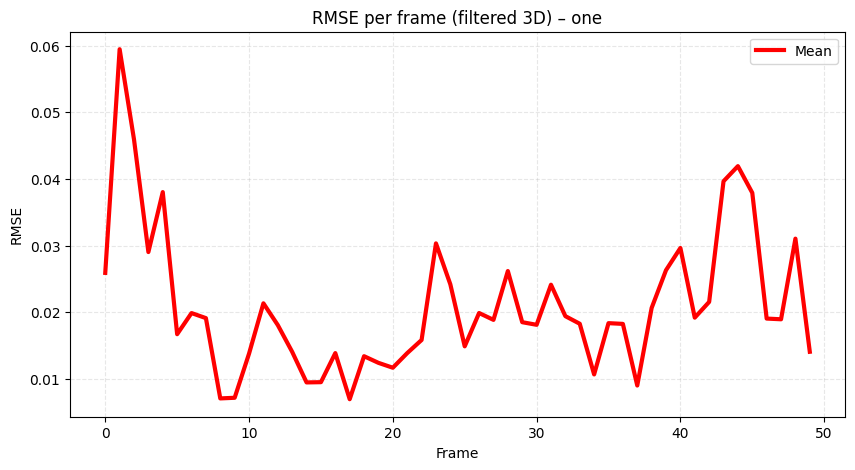

I0000 00:00:1765106641.181417    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.0235349]), array([[0.02589312, 0.0594506 , 0.04590394, 0.02901972, 0.03801274,
        0.01669188, 0.01986327, 0.01910574, 0.00705876, 0.0071546 ,
        0.01377685, 0.02132605, 0.01806148, 0.0140467 , 0.00945896,
        0.00949429, 0.01385746, 0.00693737, 0.01339174, 0.01239429,
        0.01166142, 0.01385548, 0.01582557, 0.03032157, 0.02417207,
        0.01487156, 0.01987143, 0.01884239, 0.02617072, 0.01849392,
        0.01810342, 0.02411822, 0.01940096, 0.01826017, 0.01065612,
        0.01835121, 0.01823946, 0.00899429, 0.02062967, 0.02629772,
        0.02962827, 0.01917765, 0.02153655, 0.03964163, 0.0419099 ,
        0.03790055, 0.01903741, 0.01893184, 0.03102895, 0.01405596]]), <__main__.DMPVector object at 0x7df5c9927a00>, array([[[-0.62092377,  0.38781025,  0.08199406, ...,  0.04935173,
         -1.3695751 , -0.23016029],
        [-0.60285549,  0.37197794,  0.05729167, ..., -0.31363306,
         -1.37138482, -0.18880654],
        [-0.58230854,  0.37951447,  0.1074022

I0000 00:00:1765106641.182603  564309 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/88 [00:00<?, ?it/s]W0000 00:00:1765106641.232338  564291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106641.263976  564300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 88/88 [00:02<00:00, 41.30it/s]

➡️ 1 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.0019
📈 RMSE max : 0.0019
🧹 Filtrage 3D : 1/1 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.0019
📈 RMSE max : 0.0019
📉 RMSE min : 0.0019

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/finger.joblib


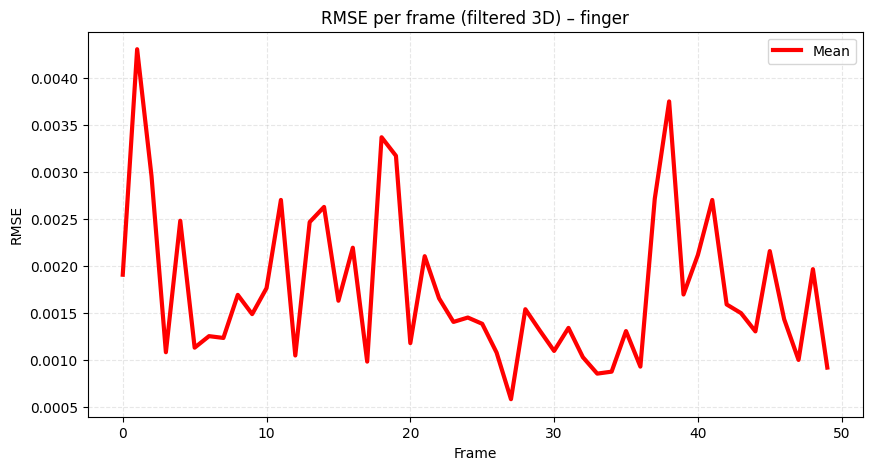

I0000 00:00:1765106643.427689    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.00192415]), array([[0.00190527, 0.00430812, 0.00295665, 0.00107945, 0.00248035,
        0.00112823, 0.00125082, 0.00123166, 0.00169045, 0.00148536,
        0.00176271, 0.00270216, 0.00104486, 0.00246632, 0.00262755,
        0.00162815, 0.00219289, 0.00097941, 0.0033702 , 0.00317242,
        0.00117651, 0.00210299, 0.00165323, 0.00140226, 0.00144902,
        0.00138227, 0.00107529, 0.00057869, 0.00153776, 0.00131152,
        0.0010931 , 0.00133855, 0.00102662, 0.00085148, 0.00087244,
        0.00130478, 0.00092607, 0.00271387, 0.00375185, 0.00169476,
        0.00211653, 0.00270178, 0.0015886 , 0.00149599, 0.00130151,
        0.00215694, 0.00143124, 0.0009974 , 0.00196452, 0.00091564]]), <__main__.DMPVector object at 0x7df5dc1fffd0>, array([[[-0.62375572,  0.45604998,  0.00987919, ...,  0.30882303,
         -1.31521108, -0.48917523],
        [-0.65087605,  0.45992275,  0.0072343 , ...,  0.26254527,
         -1.31554104, -0.45789528],
        [-0.67169259,  0.45524578,  0.006734

I0000 00:00:1765106643.428650  564360 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/33 [00:00<?, ?it/s]W0000 00:00:1765106643.491542  564344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106643.519497  564353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 33/33 [00:00<00:00, 41.41it/s]
I0000 00:00:1765106644.248607    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765106644.249893  564412 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/24 [00:00<?, ?it/s]W0000 00:00:1765106644.299870  564399 inference_feedback_manager.cc:114] Feedba

➡️ 8 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.1173
📈 RMSE max : 0.1917
🧹 Filtrage 3D : 8/8 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1173
📈 RMSE max : 0.1917
📉 RMSE min : 0.0636

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/cup.joblib


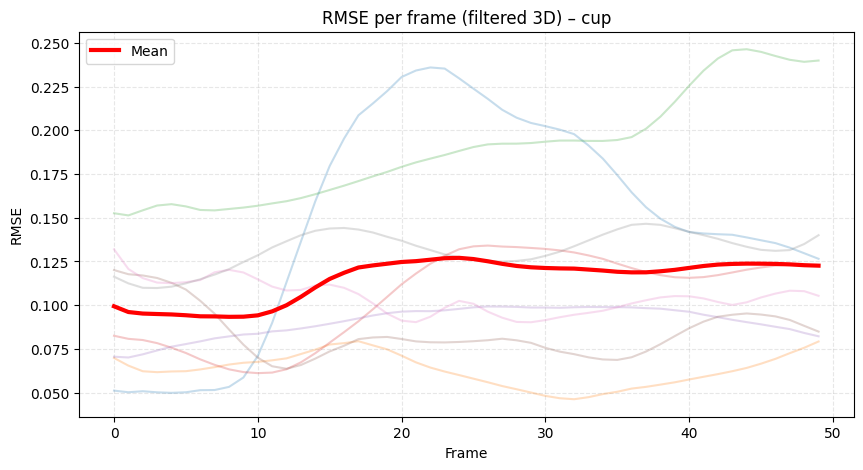

I0000 00:00:1765106650.165870    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.16171576, 0.06361571, 0.19173937, 0.10783913, 0.09071246,
       0.08563036, 0.10503369, 0.13204609]), array([[0.0510913 , 0.0501569 , 0.05074408, 0.05011354, 0.04981429,
        0.05014489, 0.0513375 , 0.05142872, 0.05322107, 0.05859075,
        0.07090494, 0.08985632, 0.11318573, 0.13638978, 0.15942993,
        0.1796003 , 0.19530199, 0.2086138 , 0.21534667, 0.22248088,
        0.23051631, 0.23423349, 0.23597706, 0.23534336, 0.22977131,
        0.22384569, 0.21800113, 0.21175388, 0.20723458, 0.20422641,
        0.2024026 , 0.20040264, 0.1978355 , 0.19137349, 0.18381854,
        0.17442336, 0.16453417, 0.15601307, 0.14946913, 0.14479438,
        0.14180995, 0.14100555, 0.14056682, 0.14025788, 0.13874124,
        0.13710392, 0.13548944, 0.13287098, 0.12969435, 0.12649741],
       [0.06976732, 0.06538789, 0.06217159, 0.06164186, 0.06204563,
        0.06220727, 0.06321674, 0.06451456, 0.06600113, 0.06702217,
        0.06753333, 0.068421  , 0.06955366, 0.07203175, 0.07451867,
  

I0000 00:00:1765106650.166643  564769 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/52 [00:00<?, ?it/s]W0000 00:00:1765106650.216100  564753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106650.241120  564761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 52/52 [00:01<00:00, 43.14it/s]


➡️ 1 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.0009
📈 RMSE max : 0.0009
🧹 Filtrage 3D : 1/1 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.0009
📈 RMSE max : 0.0009
📉 RMSE min : 0.0009

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/knock.joblib


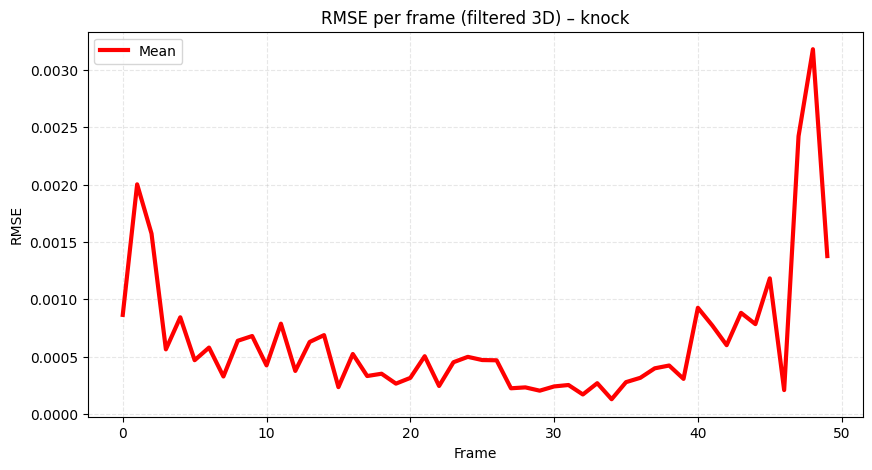

I0000 00:00:1765106651.477939    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.00086009]), array([[0.00086291, 0.00200134, 0.00157199, 0.00056245, 0.00084197,
        0.00046782, 0.00057802, 0.00032602, 0.00063735, 0.00067864,
        0.0004229 , 0.00078662, 0.00037432, 0.00062719, 0.00068664,
        0.00023306, 0.00052186, 0.00032993, 0.00034995, 0.00026365,
        0.00031367, 0.00050261, 0.00024315, 0.00045021, 0.00049707,
        0.0004693 , 0.00046708, 0.00022308, 0.00023088, 0.00020217,
        0.00023916, 0.00025157, 0.00016904, 0.00026735, 0.00012766,
        0.00027655, 0.00031459, 0.00039709, 0.00042154, 0.0003052 ,
        0.000925  , 0.00077094, 0.00059902, 0.00088096, 0.00078252,
        0.00118132, 0.00020735, 0.00242137, 0.00317966, 0.00137592]]), <__main__.DMPVector object at 0x7df5c9634ee0>, array([[[-0.5689414 ,  0.41056221,  0.06052569, ...,  0.1847674 ,
         -1.28744905, -0.26051644],
        [-0.55982492,  0.42337947,  0.06948965, ...,  0.19075484,
         -1.30397618, -0.25308601],
        [-0.55647161,  0.43028201,  0.080496

I0000 00:00:1765106651.478782  564820 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/30 [00:00<?, ?it/s]W0000 00:00:1765106651.524435  564805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106651.550618  564812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 30/30 [00:00<00:00, 39.45it/s]
I0000 00:00:1765106652.257322    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765106652.258263  564871 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/29 [00:00<?, ?it/s]W0000 00:00:1765106652.301025  564858 inference_feedback_manager.cc:114] Feedba

➡️ 5 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.0595
📈 RMSE max : 0.0772
🧹 Filtrage 3D : 5/5 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.0595
📈 RMSE max : 0.0772
📉 RMSE min : 0.0421

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/clasp.joblib


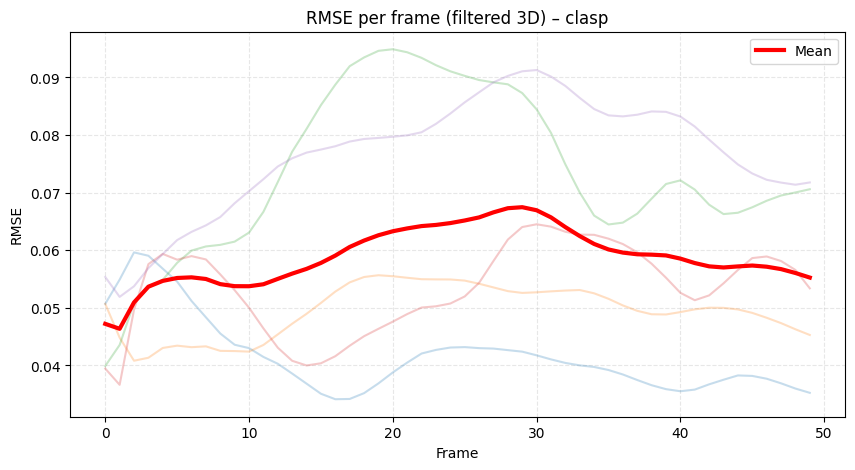

I0000 00:00:1765106656.377013    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.04208008, 0.04967857, 0.07472296, 0.05386858, 0.0772389 ]), array([[0.05069832, 0.05489293, 0.05962591, 0.05904386, 0.05679606,
        0.05455504, 0.05119072, 0.04835217, 0.04553692, 0.04358828,
        0.04300245, 0.04147006, 0.04028575, 0.03858063, 0.03683164,
        0.03507629, 0.03412668, 0.03417134, 0.0351816 , 0.03687573,
        0.03877609, 0.0404871 , 0.04206394, 0.04269042, 0.04310291,
        0.04317733, 0.04300014, 0.04292198, 0.04265249, 0.04238747,
        0.04175124, 0.04104418, 0.04042966, 0.04000564, 0.03973071,
        0.03919864, 0.03842202, 0.03746065, 0.03655763, 0.03587521,
        0.03551114, 0.03579793, 0.03671329, 0.03751004, 0.03825752,
        0.03817382, 0.03768798, 0.03688823, 0.03597948, 0.03523653],
       [0.0506802 , 0.04482276, 0.04081185, 0.04132795, 0.04303007,
        0.04342948, 0.04316424, 0.04330878, 0.04252564, 0.04249066,
        0.04239117, 0.04355229, 0.04538363, 0.04724009, 0.0489611 ,
        0.05084568, 0.05281984, 0.05441922, 0

I0000 00:00:1765106656.377861  565075 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765106656.445159  565059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106656.483566  565067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.20it/s]
I0000 00:00:1765106657.292194    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765106657.293268  565127 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/27 [00:00<?, ?it/s]W0000 00:00:1765106657.345091  565111 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip GESRes_filtered_gestures/hold/2177_Lecturer3_hold.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/122 [00:00<?, ?it/s]I0000 00:00:1765106732.948306  567181 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765106733.007513  567163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106733.031545  567173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 122/122 [00:02<00:00, 44.14it/s]
I0000 00:00:1765106735.736958    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765106735.737891  567233 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/35 [00:00<?, ?it/s]W0000 00:00:1765106735.785836  567218 inference_feedback_manager.cc:114] Fee

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip GESRes_filtered_gestures/hold/2099_Lecturer3_hold_close.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765106740.386505    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765106740.387540  567437 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/86 [00:00<?, ?it/s]W0000 00:00:1765106740.436880  567423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106740.460096  567425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 86/86 [00:01<00:00, 47.40it/s]
I0000 00:00:1765106742.221883    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765106742.223158  567488 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip GESRes_filtered_gestures/hold/2157_Lecturer3_hold_close.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/252 [00:00<?, ?it/s]W0000 00:00:1765106742.268751  567470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106742.293802  567481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 252/252 [00:05<00:00, 44.78it/s]
I0000 00:00:1765106747.892659    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765106747.893985  567539 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/40 [00:00<?, ?it/s]W0000 00:00:1765106747.946202  567521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106747.970390  567532 inference_feedback

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip GESRes_filtered_gestures/hold/2243_Lecturer3_hold.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/32 [00:00<?, ?it/s]W0000 00:00:1765106766.299262  568093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106766.326407  568103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 32/32 [00:00<00:00, 37.33it/s]
I0000 00:00:1765106767.128675    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765106767.130382  568162 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/197 [00:00<?, ?it/s]W0000 00:00:1765106767.204582  568147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106767.249230  568156 inference_feedback_m

➡️ 96 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.1719
📈 RMSE max : 1.0813
🧹 Filtrage 3D : 91/96 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1498
📈 RMSE max : 0.3413
📉 RMSE min : 0.0702

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/hold.joblib


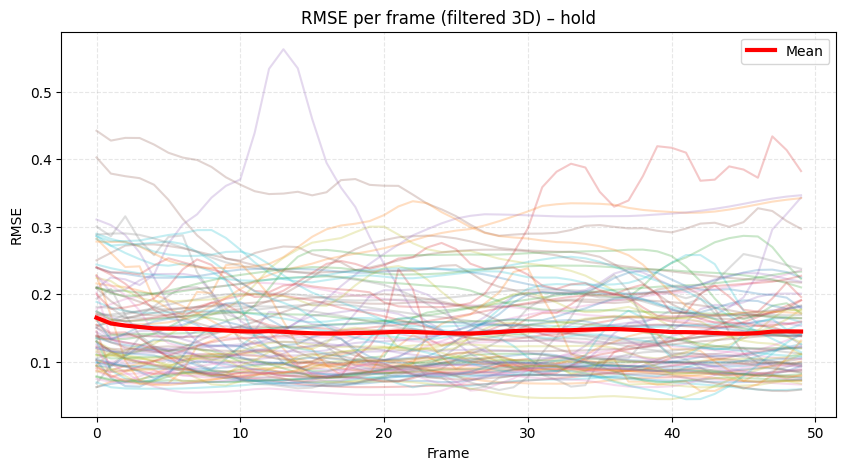

I0000 00:00:1765106833.637277    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.22524936, 0.11642243, 0.18081002, 0.10307105, 0.0968748 ,
       0.24200481, 0.18541238, 0.1125843 , 0.21384359, 0.1678935 ,
       0.09353163, 0.09306764, 0.1810165 , 0.08595202, 0.18517863,
       0.24718143, 0.12911419, 0.15881697, 0.10017079, 0.19498458,
       0.08048061, 0.09065354, 0.22546026, 0.16441746, 0.25581427,
       0.18410247, 0.0876305 , 0.18911534, 0.0877495 , 0.08276772,
       0.09281369, 0.12554019, 0.0872031 , 0.14736895, 0.16009042,
       0.12047685, 0.09731207, 0.13838222, 0.116913  , 0.07038068,
       0.08960599, 0.14898437, 0.19683897, 0.16182276, 0.1729683 ,
       0.22399616, 0.14881375, 0.09355275, 0.18747283, 0.16435187,
       0.08751479, 0.27846766, 0.09421136, 0.29281083, 0.26610901,
       0.34134484, 0.08733782, 0.16167762, 0.08011065, 0.14934154,
       0.16210862, 0.09166425, 0.08203665, 0.16968266, 0.10688019,
       0.12506666, 0.07024326, 0.15918615, 0.13366721, 0.22637855,
       0.15173422, 0.08436137, 0.15506681, 0.11298535, 0.1065

I0000 00:00:1765106833.638182  570254 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/19 [00:00<?, ?it/s]W0000 00:00:1765106833.684410  570236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106833.709933  570246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 19/19 [00:00<00:00, 37.83it/s]


➡️ 1 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.0001
📈 RMSE max : 0.0001
🧹 Filtrage 3D : 1/1 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.0001
📈 RMSE max : 0.0001
📉 RMSE min : 0.0001

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/punch.joblib


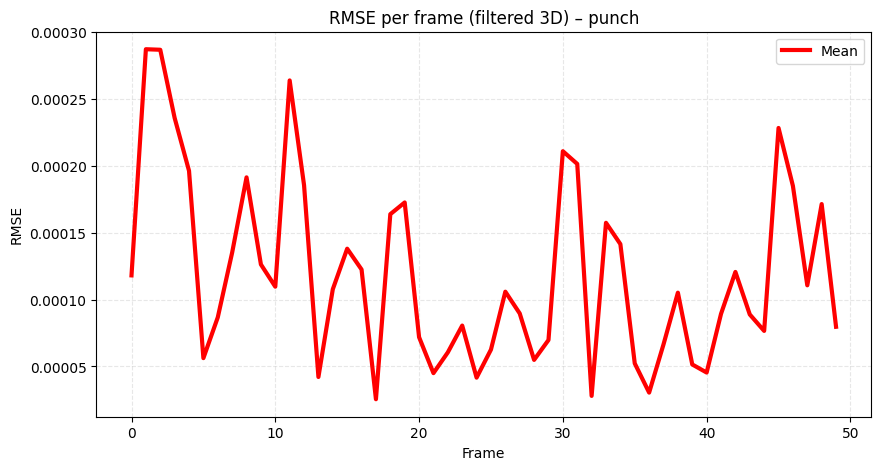

I0000 00:00:1765106834.265652    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.00013795]), array([[1.18147893e-04, 2.87375509e-04, 2.86971613e-04, 2.35961037e-04,
        1.96404061e-04, 5.62610645e-05, 8.67535066e-05, 1.35226585e-04,
        1.91498945e-04, 1.26353758e-04, 1.09702234e-04, 2.64021369e-04,
        1.85706306e-04, 4.21526036e-05, 1.07793681e-04, 1.38121252e-04,
        1.22566627e-04, 2.55039774e-05, 1.63955485e-04, 1.72719861e-04,
        7.19366996e-05, 4.50287910e-05, 6.05606647e-05, 8.06079350e-05,
        4.16470873e-05, 6.26447354e-05, 1.05949867e-04, 8.96760601e-05,
        5.49342683e-05, 6.98046649e-05, 2.11067816e-04, 2.01556552e-04,
        2.79937713e-05, 1.57506418e-04, 1.41554747e-04, 5.23091677e-05,
        3.04540845e-05, 6.65295688e-05, 1.05229886e-04, 5.15089238e-05,
        4.54617082e-05, 8.93773279e-05, 1.20730282e-04, 8.89268280e-05,
        7.66245168e-05, 2.28451208e-04, 1.85089500e-04, 1.10738728e-04,
        1.71509965e-04, 7.97044310e-05]]), <__main__.DMPVector object at 0x7df6a4e854b0>, array([[[-0.46170817,  0

I0000 00:00:1765106834.266911  570305 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/42 [00:00<?, ?it/s]W0000 00:00:1765106834.322911  570291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106834.351883  570298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 42/42 [00:01<00:00, 40.31it/s]
I0000 00:00:1765106835.336450    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765106835.337413  570356 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/32 [00:00<?, ?it/s]W0000 00:00:1765106835.381090  570344 inference_feedback_manager.cc:114] Feedba

➡️ 18 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.4889
📈 RMSE max : 0.8487
🧹 Filtrage 3D : 5/18 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.2083
📈 RMSE max : 0.3174
📉 RMSE min : 0.1533

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/point.joblib


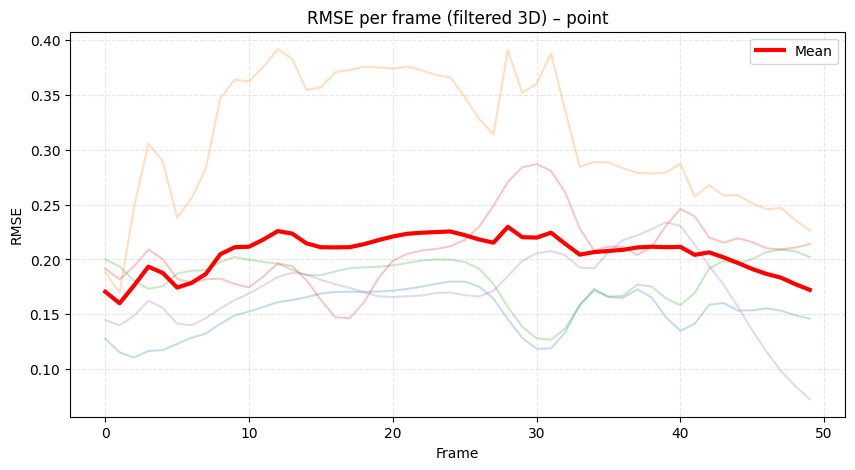

I0000 00:00:1765106860.649394    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.15334376, 0.31742724, 0.18458757, 0.2109846 , 0.174966  ]), array([[0.1276669 , 0.11517644, 0.11049408, 0.11642684, 0.11723832,
        0.1228273 , 0.12844885, 0.13232951, 0.14119136, 0.14881487,
        0.15244681, 0.15651858, 0.16097081, 0.16293678, 0.16549499,
        0.16887648, 0.17033636, 0.17054035, 0.17032956, 0.17065355,
        0.17148275, 0.1729575 , 0.17512334, 0.17773126, 0.17978578,
        0.17970406, 0.17528341, 0.1642822 , 0.14540033, 0.12836067,
        0.11849507, 0.118742  , 0.13357796, 0.15830918, 0.17302928,
        0.16574687, 0.16483246, 0.17268202, 0.1653735 , 0.14718399,
        0.13484834, 0.14133795, 0.15865103, 0.160179  , 0.15330238,
        0.15351419, 0.15535913, 0.15318279, 0.14898756, 0.14590682],
       [0.18844083, 0.16965011, 0.24753749, 0.30571154, 0.28957984,
        0.2381829 , 0.25570938, 0.28320605, 0.34690911, 0.36414003,
        0.36259285, 0.37579671, 0.39190818, 0.38309781, 0.35468735,
        0.35708385, 0.3708855 , 0.37305416, 0

I0000 00:00:1765106860.650537  571272 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/43 [00:00<?, ?it/s]W0000 00:00:1765106860.694259  571255 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106860.719622  571265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 43/43 [00:00<00:00, 43.05it/s]


➡️ 1 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.0011
📈 RMSE max : 0.0011
🧹 Filtrage 3D : 1/1 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.0011
📈 RMSE max : 0.0011
📉 RMSE min : 0.0011

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/wave.joblib


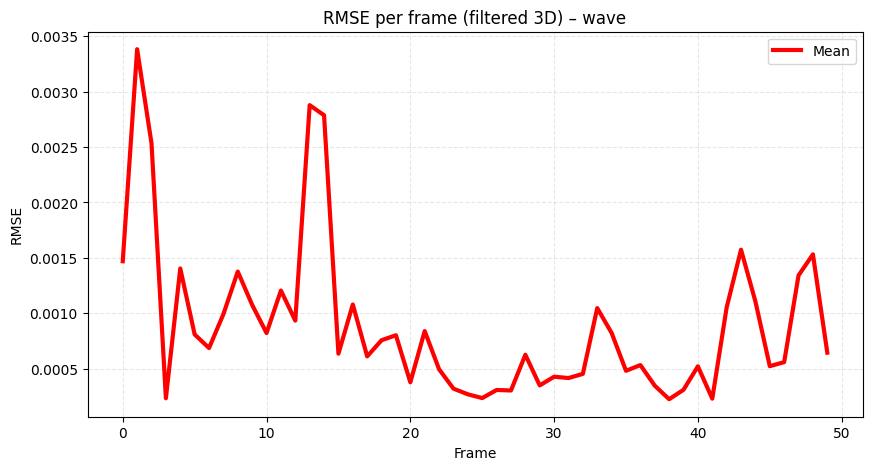

(array([0.00113841]), array([[0.00146932, 0.00338405, 0.00253365, 0.00023168, 0.0014039 ,
        0.00080819, 0.00068529, 0.00099145, 0.00137593, 0.00107503,
        0.00082063, 0.00120461, 0.00093288, 0.00287885, 0.00278798,
        0.00063444, 0.00107856, 0.00061005, 0.00075585, 0.00080074,
        0.00037591, 0.00083847, 0.00049345, 0.00031866, 0.0002674 ,
        0.00023335, 0.00030649, 0.00030203, 0.00062447, 0.00034773,
        0.00042631, 0.00041412, 0.00045219, 0.00104623, 0.0008215 ,
        0.00047973, 0.00053152, 0.00034546, 0.00022301, 0.00030842,
        0.00052001, 0.00022792, 0.00105154, 0.00157349, 0.00110616,
        0.00052138, 0.00055802, 0.00134133, 0.00153125, 0.0006434 ]]), <__main__.DMPVector object at 0x7df5c97d8790>, array([[[-0.5647464 ,  0.34548532, -0.02595847, ...,  0.28736874,
         -1.22318293, -0.2868368 ],
        [-0.54316138,  0.36484112, -0.06615681, ...,  0.35552507,
         -1.22965303, -0.2919186 ],
        [-0.53349835,  0.36896497, -0.091847

I0000 00:00:1765106861.755980    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/77 [00:00<?, ?it/s]I0000 00:00:1765106861.757236  571323 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765106861.793867  571306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106861.809524  571316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 77/77 [00:01<00:00, 43.82it/s]
I0000 00:00:1765106863.534748    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765106863.535751  571374 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip GESRes_filtered_gestures/show/1805_Lecturer2_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/42 [00:00<?, ?it/s]W0000 00:00:1765106936.144000  573939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106936.169038  573943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 42/42 [00:00<00:00, 45.32it/s]
I0000 00:00:1765106937.044604    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765106937.045914  574008 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/61 [00:00<?, ?it/s]W0000 00:00:1765106937.090921  573990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106937.114493  574002 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip GESRes_filtered_gestures/show/1923_Lecturer2_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765106972.497757  574838 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/54 [00:00<?, ?it/s]W0000 00:00:1765106972.546606  574822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106972.576492  574833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 54/54 [00:01<00:00, 42.14it/s]
I0000 00:00:1765106973.814250    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765106973.816459  574889 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/154 [00:00<?, ?it/s]W0000 00:00:1765106973.875948  574874 inference_feedback_manager.cc:114] Feedb

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip GESRes_filtered_gestures/show/2231_Lecturer3_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/30 [00:00<?, ?it/s]W0000 00:00:1765106989.233238  575143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106989.250079  575141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 30/30 [00:00<00:00, 46.97it/s]
I0000 00:00:1765106989.829550    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/73 [00:00<?, ?it/s]I0000 00:00:1765106989.830403  575209 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765106989.870505  575191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765106989.899476  575203 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip GESRes_filtered_gestures/show/1925_Lecturer2_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/23 [00:00<?, ?it/s]W0000 00:00:1765107000.286792  575602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107000.316304  575612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 23/23 [00:00<00:00, 45.03it/s]
I0000 00:00:1765107000.776882    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107000.777806  575669 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/56 [00:00<?, ?it/s]W0000 00:00:1765107000.820919  575664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107000.844798  575661 inference_feedback_ma

➡️ 86 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.3686
📈 RMSE max : 1.0687
🧹 Filtrage 3D : 56/86 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.2599
📈 RMSE max : 0.3646
📉 RMSE min : 0.1557

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/show.joblib


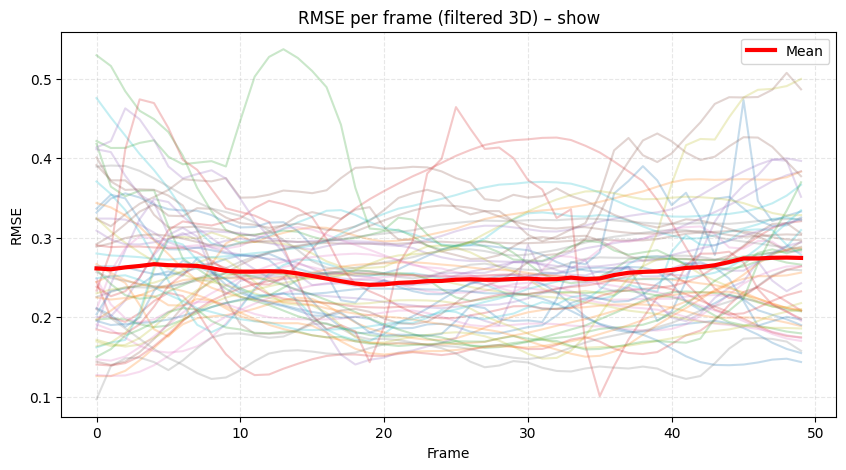

I0000 00:00:1765107012.048745    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107012.049923  575979 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.28469337, 0.19529632, 0.2229264 , 0.17760067, 0.28492184,
       0.30687997, 0.22326967, 0.15571168, 0.3119139 , 0.25875054,
       0.22327044, 0.31730155, 0.31961778, 0.3312325 , 0.27099318,
       0.27772943, 0.2069631 , 0.29917997, 0.21839882, 0.32806269,
       0.219017  , 0.24778503, 0.21406789, 0.22863115, 0.32022348,
       0.34784311, 0.22751839, 0.26165287, 0.2181975 , 0.32439028,
       0.2698516 , 0.22368591, 0.23383907, 0.26380241, 0.24626329,
       0.36461451, 0.28376001, 0.30665066, 0.21598712, 0.23573495,
       0.2631089 , 0.20062201, 0.35429091, 0.31001924, 0.28915291,
       0.31078232, 0.21951265, 0.17675469, 0.29373754, 0.23305611,
       0.20405636, 0.20467465, 0.19289224, 0.22734755, 0.2989486 ,
       0.30874839]), array([[0.33654661, 0.35412083, 0.34948184, ..., 0.3148072 , 0.31558925,
        0.32546666],
       [0.12567796, 0.12573985, 0.13237811, ..., 0.19684869, 0.19305494,
        0.18872607],
       [0.19685497, 0.19837377, 0.19717183, ..., 0.18

  0%|          | 0/32 [00:00<?, ?it/s]W0000 00:00:1765107012.095614  575962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107012.134055  575970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 32/32 [00:00<00:00, 37.23it/s]
I0000 00:00:1765107012.928052    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107012.929106  576030 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/25 [00:00<?, ?it/s]W0000 00:00:1765107012.980378  576013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107013.011173  576023 inference_feedback_ma

➡️ 3 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.3517
📈 RMSE max : 0.5253
🧹 Filtrage 3D : 2/3 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.0380
📈 RMSE max : 0.0380
📉 RMSE min : 0.0380

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/soft.joblib


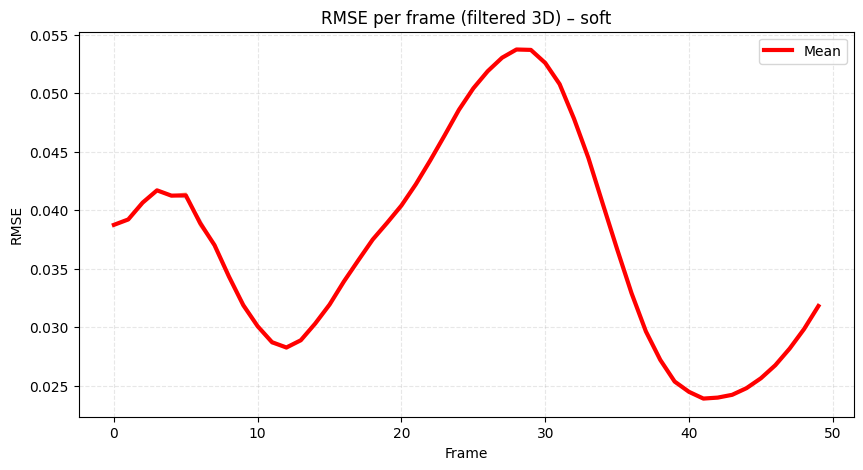

I0000 00:00:1765107014.353311    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.03799355, 0.03799321]), array([[0.03873802, 0.03920008, 0.04061073, 0.04171083, 0.0412929 ,
        0.04105316, 0.03916383, 0.03686887, 0.03421524, 0.0320262 ,
        0.03006134, 0.02857649, 0.02835841, 0.02881279, 0.03033454,
        0.03184863, 0.03398779, 0.03563356, 0.03751087, 0.03889864,
        0.04037469, 0.04222784, 0.04423887, 0.0463526 , 0.0486004 ,
        0.05040807, 0.05187022, 0.05301375, 0.05375195, 0.05370136,
        0.05251347, 0.05086868, 0.04771296, 0.04454616, 0.0404824 ,
        0.03667383, 0.03291033, 0.02958894, 0.02725689, 0.02525783,
        0.02453289, 0.02382722, 0.02400924, 0.02417357, 0.02480084,
        0.02559402, 0.02673633, 0.02821241, 0.02974282, 0.03183639],
       [0.0387294 , 0.03919439, 0.04065901, 0.04166119, 0.04117281,
        0.04146694, 0.03860815, 0.03712835, 0.03442729, 0.03171058,
        0.03006983, 0.02882229, 0.0281389 , 0.02892333, 0.03025352,
        0.0319855 , 0.03380674, 0.03577576, 0.03744546, 0.03890821,
        0.040

I0000 00:00:1765107014.354488  576132 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/49 [00:00<?, ?it/s]W0000 00:00:1765107014.453420  576118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107014.500342  576125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 49/49 [00:01<00:00, 35.80it/s]
I0000 00:00:1765107015.752161    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107015.753493  576183 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/31 [00:00<?, ?it/s]W0000 00:00:1765107015.809497  576170 inference_feedback_manager.cc:114] Feedba

➡️ 9 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.2157
📈 RMSE max : 0.3610
🧹 Filtrage 3D : 8/9 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1907
📈 RMSE max : 0.3256
📉 RMSE min : 0.1231

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/present.joblib


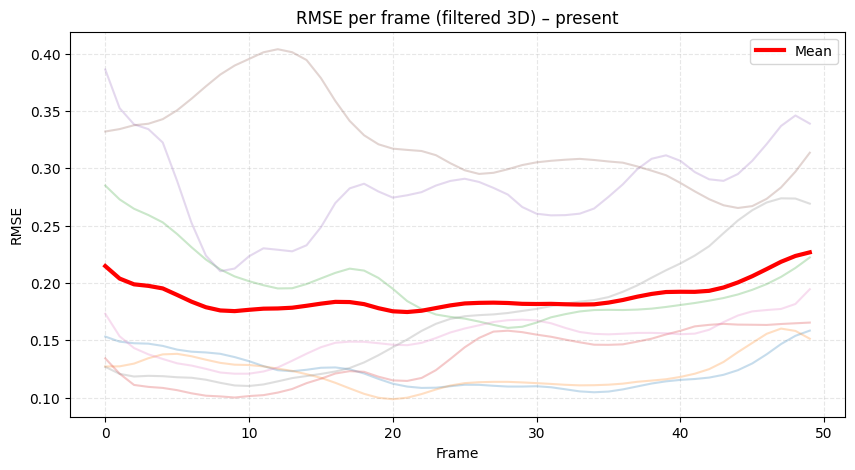

I0000 00:00:1765107027.805794    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107027.806950  576606 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.12473338, 0.12312868, 0.20023744, 0.13667753, 0.28551539,
       0.32557697, 0.15331148, 0.17674613]), array([[0.15328424, 0.14883015, 0.14747184, 0.14710098, 0.14514128,
        0.14188366, 0.1401047 , 0.13944481, 0.13825679, 0.13539712,
        0.13181452, 0.12753805, 0.12395671, 0.12306891, 0.12433001,
        0.12608681, 0.1263764 , 0.12475274, 0.1210955 , 0.11638724,
        0.11217835, 0.10968769, 0.10851691, 0.10871299, 0.11000308,
        0.11127057, 0.11121248, 0.11038027, 0.10970868, 0.10970519,
        0.10998824, 0.10909947, 0.10733077, 0.1054877 , 0.10474388,
        0.10533418, 0.1072414 , 0.10980986, 0.11235766, 0.11425087,
        0.1155106 , 0.11628864, 0.11752539, 0.11995635, 0.12398044,
        0.12987187, 0.13782572, 0.14676504, 0.15393116, 0.15847775],
       [0.1271966 , 0.12733056, 0.12971458, 0.13440584, 0.13776504,
        0.13822115, 0.13611546, 0.13311304, 0.13035249, 0.1287689 ,
        0.12848229, 0.12727698, 0.12533465, 0.12333505, 0.12047823,
  

  0%|          | 0/49 [00:00<?, ?it/s]W0000 00:00:1765107027.884309  576589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107027.918468  576594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 49/49 [00:01<00:00, 38.01it/s]
I0000 00:00:1765107029.115357    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107029.116224  576658 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/30 [00:00<?, ?it/s]W0000 00:00:1765107029.162572  576641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107029.187781  576651 inference_feedback_ma

⚠️ Skip GESRes_filtered_gestures/hand/2120_Lecturer3_hand_flip.mp4 : ValueError("If mode is 'interp', window_length must be less than or equal to the size of x.")


  0%|          | 0/16 [00:00<?, ?it/s]W0000 00:00:1765107030.263042  576751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107030.299632  576742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 16/16 [00:00<00:00, 32.54it/s]
I0000 00:00:1765107030.723666    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107030.724865  576811 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/24 [00:00<?, ?it/s]W0000 00:00:1765107030.786500  576794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107030.820014  576805 inference_feedback_ma

➡️ 11 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.2747
📈 RMSE max : 0.6138
🧹 Filtrage 3D : 9/11 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.2114
📈 RMSE max : 0.3151
📉 RMSE min : 0.0994

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/hand.joblib


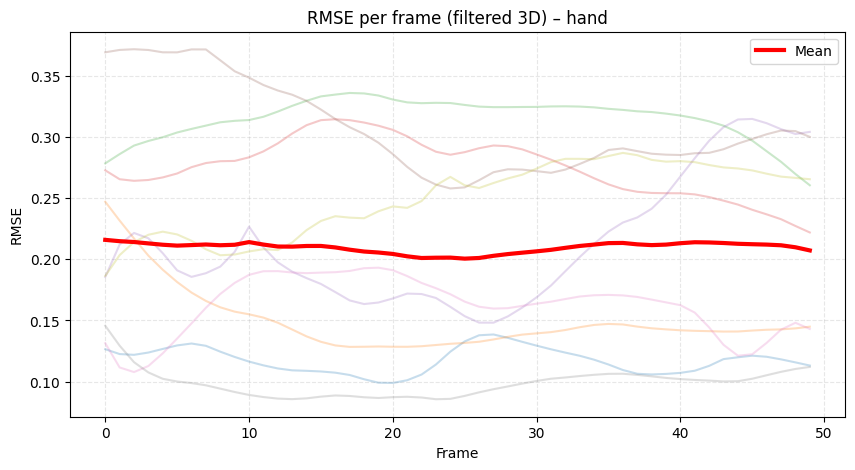

(array([0.11790066, 0.15204434, 0.3151451 , 0.27632286, 0.21821025,
       0.30982123, 0.1633097 , 0.09943225, 0.25083739]), array([[0.1264507 , 0.12247378, 0.12184946, 0.12372455, 0.12666964,
        0.12953981, 0.13110563, 0.12922737, 0.12442878, 0.120122  ,
        0.11631242, 0.11323298, 0.11069668, 0.10915946, 0.10876499,
        0.10823656, 0.10724699, 0.10535817, 0.10187463, 0.09904153,
        0.09884301, 0.10106708, 0.10572713, 0.11393346, 0.12442898,
        0.13283958, 0.13785246, 0.13849926, 0.13575697, 0.13248866,
        0.12935426, 0.126387  , 0.12365864, 0.12107489, 0.11786315,
        0.11392316, 0.10942195, 0.10634513, 0.10580601, 0.10622891,
        0.10708653, 0.10883965, 0.11282059, 0.11834717, 0.11984267,
        0.12114596, 0.12026113, 0.11813765, 0.11566912, 0.1130824 ],
       [0.24709059, 0.23169768, 0.21704339, 0.20299682, 0.1914596 ,
        0.18140283, 0.17276722, 0.16593897, 0.16072199, 0.15717573,
        0.1550067 , 0.15230464, 0.14813733, 0.14255952, 0.

In [96]:
def analyse_full_DESRes(): 
    for i in labels_DESRes:
        print(analyse_label_filtered_3D(i, n = 100, target_len=50, n_basis=30)) 
    
analyse_full_DESRes()

I0000 00:00:1765107597.705165    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107597.705993  607887 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)



🔎 Extraction vidéos du label 'Stop Sign' (3D) ...


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107597.754619  607874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107597.781836  607881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.54it/s]
I0000 00:00:1765107598.623316    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107598.624232  607938 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107598.676642  607923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107598.703044  607933 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Stop Sign/93751.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107603.045763  608179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107603.068053  608185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.22it/s]
I0000 00:00:1765107603.923997    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107603.926002  608245 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107603.974108  608229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107604.000976  608235 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Stop Sign/24055.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107632.278418  609813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107632.303894  609824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.61it/s]
I0000 00:00:1765107633.182869    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107633.184370  609883 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107633.227583  609865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107633.254137  609877 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Stop Sign/40346.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107644.742923  610478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107644.770294  610489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.32it/s]
I0000 00:00:1765107645.661423    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107645.662654  610547 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107645.721710  610529 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107645.750889  610539 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Stop Sign/76670.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765107661.128036  611416 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107661.174328  611402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107661.201183  611412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.36it/s]
I0000 00:00:1765107662.030238    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107662.031581  611467 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107662.083873  611453 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Stop Sign/28522.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765107692.237995  613105 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107692.299354  613087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107692.327085  613098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.41it/s]
I0000 00:00:1765107693.179158    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107693.180173  613156 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107693.229898  613139 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Stop Sign/69133.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107720.842338  614672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107720.868305  614682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.11it/s]
I0000 00:00:1765107721.697378    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107721.699301  614739 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107721.744695  614723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107721.766796  614734 inference_feedback_ma

➡️ 144 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.4683
📈 RMSE max : 1.0436
🧹 Filtrage 3D : 29/144 vidéos gardées (< 0.3)

📊 RMSE moyen après filtrage : 0.1267
📈 RMSE max : 0.2563
📉 RMSE min : 0.0793

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/Stop Sign.joblib


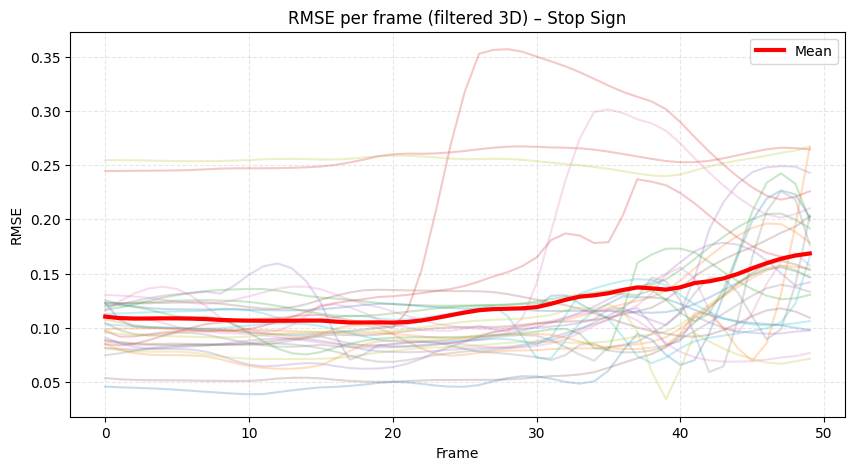

(array([0.11416048, 0.10159315, 0.14194503, 0.25630205, 0.08982303,
       0.07932683, 0.10618196, 0.0918516 , 0.25378194, 0.10633945,
       0.11769189, 0.12116652, 0.13610995, 0.22992694, 0.12394486,
       0.11614756, 0.17841917, 0.09899013, 0.09493379, 0.10611677,
       0.08936392, 0.09501709, 0.11339778, 0.15303377, 0.12835833,
       0.11987542, 0.10985123, 0.10584978, 0.09468731]), array([[0.12300743, 0.10709423, 0.10099453, ..., 0.15575983, 0.15221247,
        0.14648884],
       [0.10756824, 0.10478341, 0.10245254, ..., 0.15690046, 0.15622314,
        0.15436902],
       [0.11664888, 0.11848746, 0.12137363, ..., 0.20531114, 0.19963557,
        0.19173531],
       ...,
       [0.13014835, 0.12969823, 0.12879546, ..., 0.07245134, 0.07377594,
        0.07662168],
       [0.07457246, 0.07623528, 0.07853405, ..., 0.225854  , 0.21842936,
        0.17634146],
       [0.09553666, 0.09423944, 0.09341634, ..., 0.06652584, 0.06891153,
        0.07138103]]), <__main__.DMPVector object at

I0000 00:00:1765107736.743946    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107736.744926  615557 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107736.786594  615540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107736.813710  615551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 45.95it/s]
I0000 00:00:1765107737.581971    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107737.583448  615608 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/44517.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765107755.898139  616631 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107755.941253  616626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107755.966999  616625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.44it/s]
I0000 00:00:1765107756.848888    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107756.850063  616682 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107756.899611  616667 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/58933.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107757.844932  616718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107757.875763  616727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.20it/s]
I0000 00:00:1765107758.720625    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107758.722738  616784 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107758.785263  616769 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107758.812332  616776 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/65620.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107778.190223  617841 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107778.220687  617849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.27it/s]
I0000 00:00:1765107779.076951    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107779.078358  617909 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107779.124881  617892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107779.150455  617896 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/106386.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107790.200561  618510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107790.234694  618515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.69it/s]
I0000 00:00:1765107791.055208    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107791.056763  618575 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107791.102860  618558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107791.129825  618565 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/71137.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107797.244268  618918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107797.275215  618921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.92it/s]
I0000 00:00:1765107798.156168    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107798.157594  618984 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107798.207546  618970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107798.230338  618974 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/131742.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765107810.317835    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107810.318706  619650 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107810.366020  619632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107810.390755  619643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.35it/s]
I0000 00:00:1765107811.214987    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107811.216724  619701 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/49926.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107821.482402  620245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107821.511026  620255 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.06it/s]
I0000 00:00:1765107822.393983    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107822.395121  620314 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107822.439457  620298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107822.463185  620308 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/31667.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765107857.404558  622259 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107857.453404  622244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107857.482047  622254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.91it/s]
I0000 00:00:1765107858.370339    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107858.371983  622310 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107858.433196  622293 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/66619.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107862.034619  622499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107862.061958  622507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.22it/s]
I0000 00:00:1765107862.848329    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107862.849613  622567 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107862.896854  622556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107862.921953  622562 inference_feedback_ma

➡️ 141 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.4078
📈 RMSE max : 0.9323
🧹 Filtrage 3D : 48/141 vidéos gardées (< 0.3)

📊 RMSE moyen après filtrage : 0.1318
📈 RMSE max : 0.3045
📉 RMSE min : 0.0699

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/Drumming Fingers.joblib


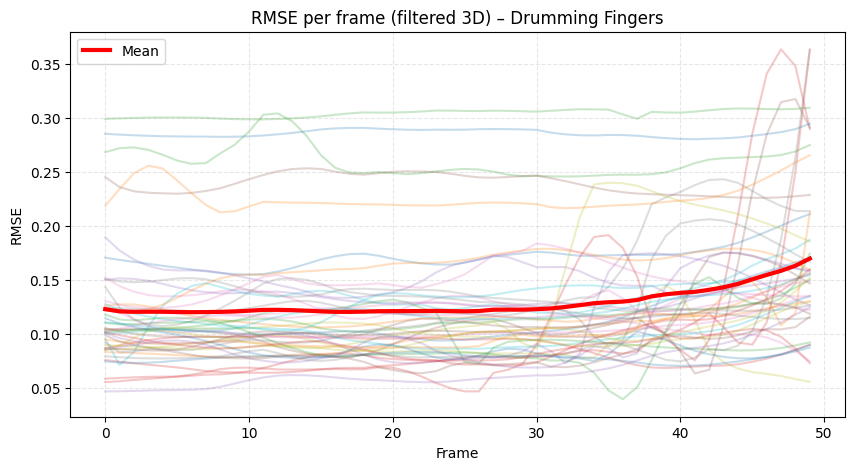

I0000 00:00:1765107875.057137    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.11507575, 0.10282228, 0.26091661, 0.08936648, 0.13550099,
       0.10606959, 0.12202731, 0.1405337 , 0.08978732, 0.13512036,
       0.17247447, 0.11618327, 0.11496294, 0.13006811, 0.11457088,
       0.11788434, 0.10593616, 0.14799186, 0.1512629 , 0.10030447,
       0.08201117, 0.16258261, 0.10488061, 0.10342235, 0.15339578,
       0.13093646, 0.14856735, 0.12652397, 0.09916962, 0.13377717,
       0.08345063, 0.10444704, 0.10136921, 0.09334229, 0.06986947,
       0.23925055, 0.12715705, 0.1348775 , 0.10202097, 0.12133586,
       0.28607781, 0.22696782, 0.30447339, 0.09808303, 0.10754451,
       0.08364789, 0.12020864, 0.10581535]), array([[0.10328176, 0.10370626, 0.10394199, ..., 0.16205333, 0.1665647 ,
        0.17033461],
       [0.08320641, 0.08293566, 0.08238252, ..., 0.145222  , 0.15126421,
        0.15609836],
       [0.26850837, 0.27224759, 0.27294235, ..., 0.26587215, 0.26919166,
        0.27515693],
       ...,
       [0.09873827, 0.09307938, 0.08985204, ..., 0.104335

I0000 00:00:1765107875.058459  623231 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107875.099072  623216 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107875.115923  623223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 46.58it/s]
I0000 00:00:1765107875.886970    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107875.888359  623282 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107875.935704  623264 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Up/23237.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765107910.422389  625173 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107910.473084  625157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107910.500142  625167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.50it/s]
I0000 00:00:1765107911.394767    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107911.396070  625224 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107911.460364  625209 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Up/79908.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107949.490928  627304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107949.516491  627314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.48it/s]
I0000 00:00:1765107950.400616    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107950.402711  627372 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107950.458125  627356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107950.489291  627364 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Up/81077.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765107978.247324  628906 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107978.291842  628888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765107978.319468  628898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.36it/s]
I0000 00:00:1765107979.146318    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765107979.147306  628957 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765107979.192759  628948 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Up/144708.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765108007.255074  630489 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765108007.307741  630482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108007.333471  630477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.74it/s]
I0000 00:00:1765108008.159617    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108008.160426  630540 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108008.208475  630527 inference_feedback_manager.cc:114] Feedba

➡️ 146 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.4848
📈 RMSE max : 0.9877
🧹 Filtrage 3D : 9/146 vidéos gardées (< 0.3)

📊 RMSE moyen après filtrage : 0.1074
📈 RMSE max : 0.1963
📉 RMSE min : 0.0686

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/Thumb Up.joblib


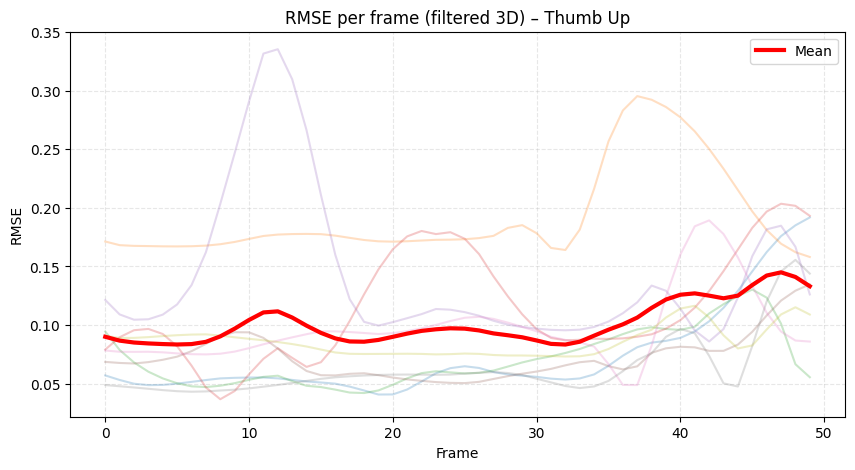

I0000 00:00:1765108014.994347    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.08225822, 0.1963131 , 0.07513934, 0.12344306, 0.15634196,
       0.07537179, 0.10175037, 0.06860312, 0.0871069 ]), array([[0.05704123, 0.05315632, 0.04994789, 0.04874454, 0.04894613,
        0.05002803, 0.05153103, 0.05308778, 0.05448996, 0.05498724,
        0.05523964, 0.05527317, 0.05453007, 0.05320391, 0.05189497,
        0.05101044, 0.04999898, 0.04749863, 0.04419188, 0.04074105,
        0.04082112, 0.04503226, 0.05183895, 0.0588935 , 0.06322917,
        0.06486408, 0.06339323, 0.05989721, 0.05788667, 0.05681922,
        0.05581464, 0.0542827 , 0.0535155 , 0.05444562, 0.05788758,
        0.06524038, 0.07388565, 0.08110401, 0.0850212 , 0.08652413,
        0.08906422, 0.09456278, 0.10320956, 0.11469031, 0.12918046,
        0.14582115, 0.16223284, 0.17588436, 0.1850749 , 0.19183604],
       [0.17127588, 0.1681667 , 0.16755323, 0.16738572, 0.16716055,
        0.1670957 , 0.16724555, 0.16777056, 0.16895772, 0.17090466,
        0.17349383, 0.17599403, 0.17719427, 0.17763401, 0.

I0000 00:00:1765108014.995213  630898 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108015.044791  630880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108015.074457  630889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.32it/s]
I0000 00:00:1765108015.942398    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108015.944818  630950 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108015.994178  630932 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/105636.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108020.557451  631205 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108020.610132  631192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108020.639120  631200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.61it/s]
I0000 00:00:1765108021.443161    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108021.443939  631256 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108021.485894  631248 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/7779.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108064.138333  633610 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108064.184501  633605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108064.214274  633602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.03it/s]
I0000 00:00:1765108065.085245    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108065.086096  633661 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108065.141311  633644 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/86753.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108067.016550  633746 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108067.043332  633754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.31it/s]
I0000 00:00:1765108067.917208    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108067.918169  633814 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108067.963078  633797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108067.989462  633807 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/32970.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108074.424313    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108074.425909  634172 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108074.478039  634154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108074.506116  634163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.21it/s]
I0000 00:00:1765108075.368926    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108075.369917  634223 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/97834.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108080.791276  634515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108080.814392  634521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.14it/s]
I0000 00:00:1765108081.655682    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108081.656766  634581 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108081.704727  634569 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108081.731040  634573 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/25045.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108094.667805    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108094.668640  635302 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108094.712057  635290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108094.740634  635295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 46.84it/s]
I0000 00:00:1765108095.479302    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108095.480135  635353 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/119760.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108095.523987  635335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108095.553985  635345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.68it/s]
I0000 00:00:1765108096.476231    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108096.477769  635405 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108096.537227  635390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108096.564508  635388 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/19144.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108109.072736  636110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108109.102826  636117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.26it/s]
I0000 00:00:1765108110.009847    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108110.011001  636175 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108110.053591  636159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108110.087266  636171 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/72975.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108121.150361  636770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108121.172262  636775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.20it/s]
I0000 00:00:1765108122.005445    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108122.006689  636838 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108122.040745  636829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108122.072634  636830 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/117712.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108124.863375  636977 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108124.898616  636986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.47it/s]
I0000 00:00:1765108125.815896    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108125.817445  637043 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108125.863850  637025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108125.886756  637029 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/81876.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108131.359718  637335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108131.387054  637339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.89it/s]
I0000 00:00:1765108132.265733    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108132.267991  637400 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108132.320702  637386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108132.352709  637392 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/86931.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108136.874554    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765108136.875564  637657 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765108136.926127  637643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108136.953184  637651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.32it/s]
I0000 00:00:1765108137.848823    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765108137.851011  637708 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: M

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/112798.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108152.742552  638509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108152.768927  638520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.42it/s]


➡️ 137 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.4883
📈 RMSE max : 1.1712
🧹 Filtrage 3D : 29/137 vidéos gardées (< 0.3)

📊 RMSE moyen après filtrage : 0.1422
📈 RMSE max : 0.2999
📉 RMSE min : 0.0867

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/Thumb Down.joblib


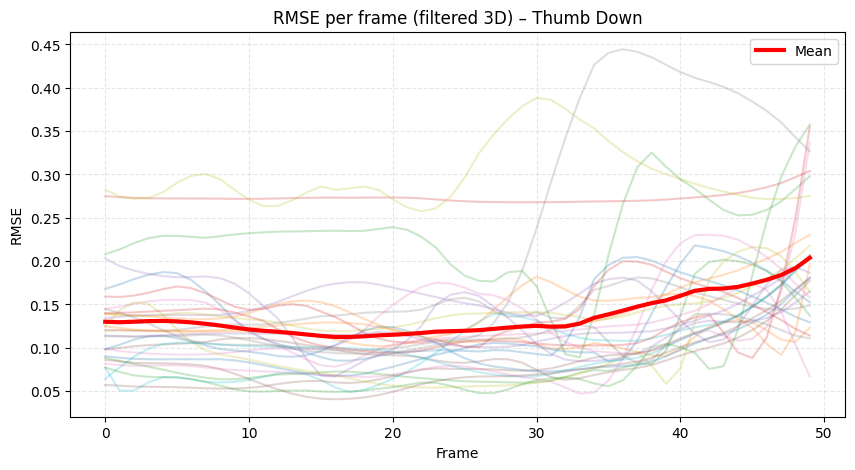

I0000 00:00:1765108153.730665    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.14267353, 0.12297917, 0.23257077, 0.27365419, 0.15417573,
       0.10012556, 0.1312226 , 0.14417594, 0.14337833, 0.10650007,
       0.11999026, 0.13447721, 0.10219641, 0.14773714, 0.1363321 ,
       0.09281692, 0.12650133, 0.2613709 , 0.11210859, 0.10550551,
       0.10505752, 0.14306546, 0.11115787, 0.13100736, 0.12428807,
       0.08674804, 0.11939132, 0.11143671, 0.29994648]), array([[0.16786871, 0.17311625, 0.17915812, ..., 0.14422892, 0.1357447 ,
        0.12938078],
       [0.13893137, 0.13826997, 0.13747386, ..., 0.10945368, 0.10674107,
        0.12316047],
       [0.20808575, 0.21345589, 0.22074696, ..., 0.26866087, 0.28305468,
        0.29782331],
       ...,
       [0.08132247, 0.0801059 , 0.07923178, ..., 0.19105924, 0.17384187,
        0.15806938],
       [0.11404625, 0.11355323, 0.1128341 , ..., 0.12051726, 0.11387883,
        0.11086207],
       [0.28204853, 0.27462415, 0.27191843, ..., 0.27161422, 0.27276149,
        0.27520105]]), <__main__.DMPVector object at

I0000 00:00:1765108153.731871  638578 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108153.762819  638564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108153.810047  638572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.89it/s]
I0000 00:00:1765108154.625463    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108154.626811  638629 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108154.684543  638615 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/61670.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108165.931321  639226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108165.960396  639234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:01<00:00, 36.51it/s]
I0000 00:00:1765108166.925876    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108166.927471  639293 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108166.985454  639279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108167.010956  639287 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/56389.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108180.676341  640043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108180.703859  640051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.06it/s]
I0000 00:00:1765108181.557664    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108181.559114  640111 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108181.616756  640096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108181.628961  640106 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/77657.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108208.816444  641580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108208.842029  641582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 45.88it/s]
I0000 00:00:1765108209.593354    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108209.594124  641643 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108209.636390  641626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108209.666265  641635 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/21416.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108249.477843  643844 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108249.563592  643837 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108249.610195  643836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.26it/s]
I0000 00:00:1765108250.404946    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108250.406048  643895 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108250.456042  643880 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/44315.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108262.714503  644549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108262.742790  644551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.76it/s]
I0000 00:00:1765108263.603709    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108263.604825  644611 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108263.663863  644599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108263.690849  644605 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/8176.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108268.402583  644866 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108268.446482  644848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108268.479869  644857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.98it/s]
I0000 00:00:1765108269.271889    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108269.272854  644917 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108269.317161  644904 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/88539.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108289.015399  645994 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108289.058912  645977 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108289.086800  645987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.42it/s]
I0000 00:00:1765108289.896744    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108289.898405  646045 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108289.956322  646027 inference_feedback_manager.cc:114] Feedba

➡️ 143 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.4182
📈 RMSE max : 1.0089
🧹 Filtrage 3D : 53/143 vidéos gardées (< 0.3)

📊 RMSE moyen après filtrage : 0.1425
📈 RMSE max : 0.2881
📉 RMSE min : 0.0729

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/Turning Hand Counterclockwise.joblib


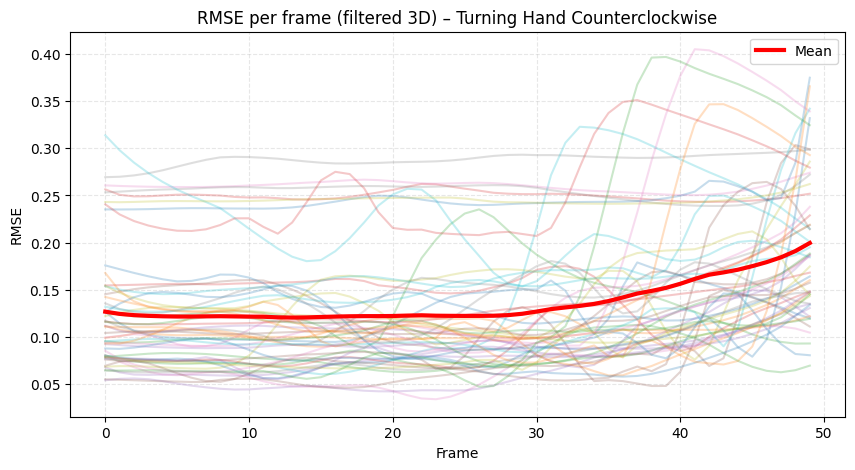

I0000 00:00:1765108293.914378    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.12886214, 0.11018096, 0.09876402, 0.14750286, 0.08299323,
       0.13815422, 0.07286145, 0.2880602 , 0.14985131, 0.18749201,
       0.14010453, 0.12737537, 0.14554083, 0.24998849, 0.079461  ,
       0.10467763, 0.13476032, 0.14541919, 0.11548379, 0.17529989,
       0.09996589, 0.11435039, 0.08113352, 0.11897429, 0.10569904,
       0.0929476 , 0.25990417, 0.25423136, 0.14825487, 0.21471734,
       0.247588  , 0.10261846, 0.10618664, 0.13026785, 0.10302632,
       0.11594288, 0.11475999, 0.08814004, 0.24518293, 0.12733451,
       0.08118557, 0.17388405, 0.10465918, 0.26110865, 0.08737788,
       0.11710705, 0.19880936, 0.14182442, 0.0922147 , 0.15307079,
       0.11549044, 0.12421449, 0.2077513 ]), array([[0.1265248 , 0.11449496, 0.10653461, ..., 0.1314083 , 0.12496025,
        0.11982895],
       [0.09916376, 0.10085919, 0.10356226, ..., 0.14126355, 0.15084141,
        0.16022416],
       [0.07901847, 0.08012645, 0.08118095, ..., 0.16682359, 0.17755442,
        0.18845405],
  

I0000 00:00:1765108293.915195  646250 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108293.959158  646233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108293.985774  646242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.89it/s]
I0000 00:00:1765108294.854789    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108294.856218  646301 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108294.908031  646284 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/76104.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108306.206573  646896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108306.235006  646904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.69it/s]
I0000 00:00:1765108307.108528    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108307.110256  646964 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108307.165711  646950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108307.192872  646951 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/122007.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108315.544663  647425 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108315.586090  647411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108315.609628  647417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.45it/s]
I0000 00:00:1765108316.438642    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108316.440272  647477 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108316.491159  647462 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/147728.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108317.356291  647510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108317.383788  647521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.93it/s]
I0000 00:00:1765108318.215842    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108318.216907  647579 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108318.263742  647562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108318.289289  647571 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/144363.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108357.217167  649724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108357.231081  649719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.05it/s]
I0000 00:00:1765108358.095014    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108358.096061  649780 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108358.142023  649765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108358.166468  649773 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/120687.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108363.629268  650087 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108363.678203  650071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108363.704708  650080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.30it/s]
I0000 00:00:1765108364.598973    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108364.599898  650138 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108364.639267  650126 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/18093.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108375.601869    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108375.603453  650752 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108375.652105  650741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108375.680292  650734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.36it/s]
I0000 00:00:1765108376.539640    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765108376.541089  650803 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: M

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/38803.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108382.104940  651109 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108382.151374  651097 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108382.179012  651103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.14it/s]
I0000 00:00:1765108383.027687    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108383.028677  651160 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108383.077648  651149 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/65534.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108398.708008  652013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108398.737401  652025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.26it/s]
I0000 00:00:1765108399.564790    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108399.566351  652082 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108399.619394  652066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108399.645534  652073 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/25607.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108405.999688  652441 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108406.055356  652423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108406.080814  652437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.46it/s]
I0000 00:00:1765108406.863734    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108406.864848  652498 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108406.916779  652483 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/50289.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108423.531888  653418 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108423.571463  653406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108423.602399  653409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.22it/s]
I0000 00:00:1765108424.479961    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108424.480887  653469 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108424.526091  653451 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/21991.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108426.151369  653559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108426.186249  653555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.14it/s]
I0000 00:00:1765108427.054233    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108427.057261  653623 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108427.101334  653609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108427.127931  653617 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/29203.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108429.860807    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108429.861622  653776 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108429.904425  653759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108429.930557  653772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.45it/s]
I0000 00:00:1765108430.757178    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108430.757993  653827 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

➡️ 138 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.4392
📈 RMSE max : 0.9720
🧹 Filtrage 3D : 41/138 vidéos gardées (< 0.3)

📊 RMSE moyen après filtrage : 0.1359
📈 RMSE max : 0.3442
📉 RMSE min : 0.0703

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/Turning Hand Clockwise.joblib


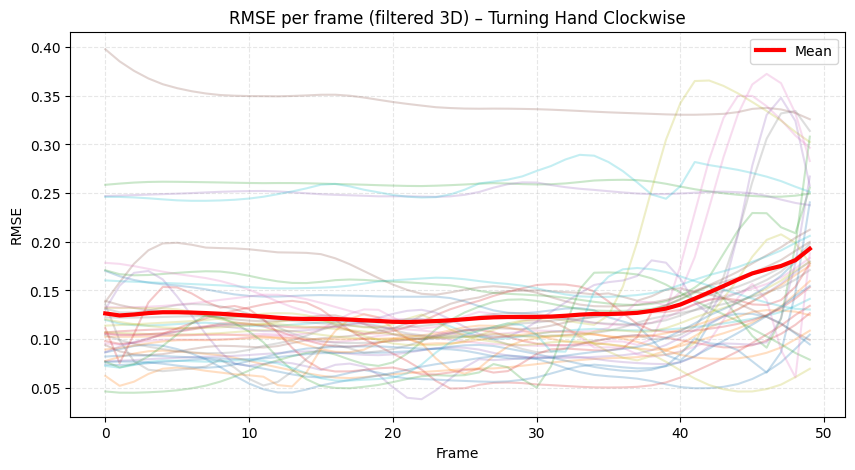

I0000 00:00:1765108432.894740    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.13479665, 0.08588127, 0.25808309, 0.10337996, 0.09776475,
       0.12223426, 0.16213269, 0.14624029, 0.19007023, 0.11477612,
       0.07028542, 0.10604798, 0.11581662, 0.09342495, 0.25006487,
       0.16629799, 0.1231997 , 0.11263897, 0.12189906, 0.25840282,
       0.09092191, 0.10292056, 0.16600952, 0.12325559, 0.1015256 ,
       0.13300447, 0.1790558 , 0.12766518, 0.10327775, 0.15983368,
       0.07947567, 0.09311192, 0.10295397, 0.10973484, 0.15579866,
       0.34419094, 0.12367372, 0.11425298, 0.11711306, 0.11046848,
       0.10054726]), array([[0.17012816, 0.16453369, 0.16071519, ..., 0.11623008, 0.10569023,
        0.09452882],
       [0.07745658, 0.08161964, 0.08515066, ..., 0.12925541, 0.1281654 ,
        0.12458623],
       [0.25853397, 0.25978107, 0.26083061, ..., 0.24631715, 0.24735512,
        0.2495005 ],
       ...,
       [0.12031027, 0.11758586, 0.11532836, ..., 0.16003783, 0.17030102,
        0.17934491],
       [0.07237788, 0.07065817, 0.0733817 , ..., 0.133

I0000 00:00:1765108432.895793  653930 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108432.940652  653915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108432.975465  653926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.39it/s]
I0000 00:00:1765108433.766163    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108433.767231  653981 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108433.814412  653963 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/88522.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108443.259412  654476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108443.288109  654488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.51it/s]
I0000 00:00:1765108444.163879    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108444.165501  654543 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108444.211391  654528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108444.238325  654533 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/142301.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108459.499914  655413 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108459.560151  655396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108459.600805  655403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.53it/s]
I0000 00:00:1765108460.449746    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108460.450905  655465 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108460.497603  655449 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/15227.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108510.644158  658265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108510.673712  658262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.76it/s]
I0000 00:00:1765108511.475376    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108511.476619  658333 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108511.522331  658316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108511.548583  658326 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/78230.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108528.844532  659293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108528.873702  659304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.79it/s]
I0000 00:00:1765108529.654650    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108529.655519  659361 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108529.698683  659345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108529.722622  659356 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/100884.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108538.531188  659866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108538.553960  659863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.43it/s]
I0000 00:00:1765108539.384267    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108539.385830  659922 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108539.441755  659904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108539.466520  659916 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/121000.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108570.786612  661464 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108570.833381  661448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108570.859650  661456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.41it/s]
I0000 00:00:1765108571.642432    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108571.643518  661516 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108571.694380  661499 inference_feedback_manager.cc:114] Feedba

➡️ 144 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.4283
📈 RMSE max : 0.9833
🧹 Filtrage 3D : 49/144 vidéos gardées (< 0.3)

📊 RMSE moyen après filtrage : 0.1230
📈 RMSE max : 0.1744
📉 RMSE min : 0.0729

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/Rolling Hand Backward.joblib


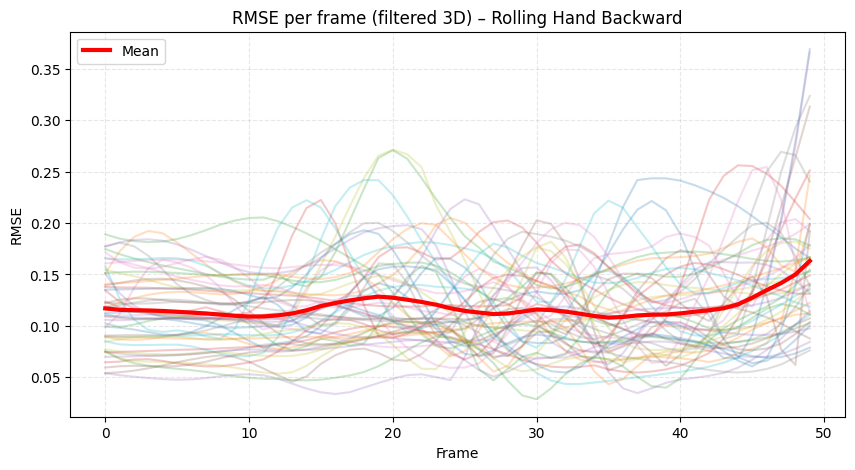

I0000 00:00:1765108573.643959    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108573.645304  661618 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.15380221, 0.09452308, 0.17443001, 0.13981986, 0.07454897,
       0.13214844, 0.11275542, 0.09762046, 0.14914525, 0.11627789,
       0.12382497, 0.1440665 , 0.13774621, 0.09750098, 0.07537491,
       0.09941972, 0.16518967, 0.12532801, 0.12987808, 0.11286818,
       0.10116485, 0.11130498, 0.1362307 , 0.10529266, 0.14904724,
       0.10662049, 0.13167497, 0.15130769, 0.0862873 , 0.16111029,
       0.10786376, 0.10922305, 0.12213057, 0.15391755, 0.10286095,
       0.08460957, 0.14438636, 0.12999414, 0.10624723, 0.14601092,
       0.13795833, 0.15971141, 0.07287398, 0.13313603, 0.13210411,
       0.1163638 , 0.14064816, 0.12438157, 0.10468399]), array([[0.11257765, 0.11290259, 0.11361322, ..., 0.18626678, 0.17518939,
        0.16601949],
       [0.08949328, 0.08688639, 0.08635765, ..., 0.10368613, 0.15579118,
        0.24596889],
       [0.17463284, 0.16974756, 0.1656022 , ..., 0.16253656, 0.16362882,
        0.1667111 ],
       ...,
       [0.17145519, 0.16182546, 0.15667908, .

  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108573.703899  661603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108573.729069  661611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.14it/s]
I0000 00:00:1765108574.525586    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108574.526486  661669 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108574.570712  661656 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108574.597170  661665 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/44587.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108591.458969  662593 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108591.524861  662581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108591.584032  662585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:01<00:00, 25.08it/s]
I0000 00:00:1765108592.960158    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108592.961703  662644 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108593.053675  662627 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/70030.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108597.688788  662779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108597.734648  662788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:01<00:00, 26.23it/s]
I0000 00:00:1765108599.040902    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108599.042050  662848 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108599.139306  662843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108599.183663  662842 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/81958.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108615.819833  663755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108615.865616  663765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.23it/s]
I0000 00:00:1765108616.684201    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108616.684920  663820 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108616.727938  663806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108616.749466  663812 inference_feedback_ma

➡️ 147 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.3870
📈 RMSE max : 1.0169
🧹 Filtrage 3D : 78/147 vidéos gardées (< 0.3)

📊 RMSE moyen après filtrage : 0.1321
📈 RMSE max : 0.2440
📉 RMSE min : 0.0692

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/Rolling Hand Forward.joblib


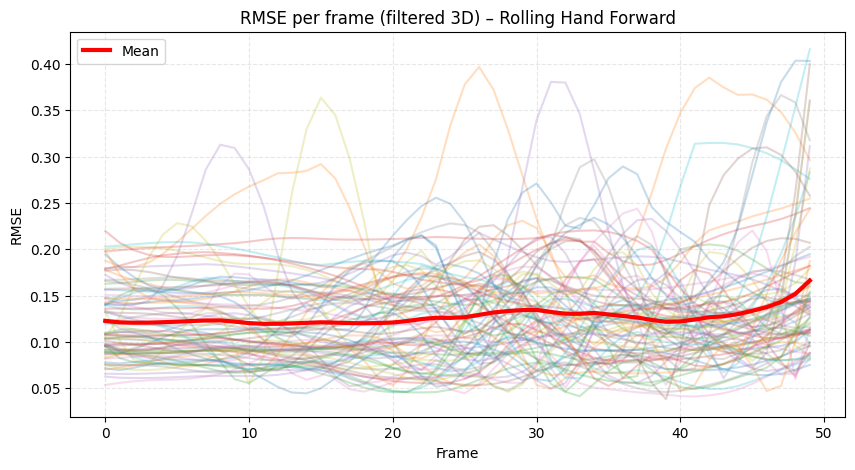

I0000 00:00:1765108718.838446    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.11062936, 0.24400702, 0.10006015, 0.11645928, 0.15674182,
       0.11244871, 0.11905372, 0.11512484, 0.15988029, 0.07726848,
       0.1122587 , 0.2125926 , 0.12359302, 0.20949422, 0.1777221 ,
       0.14311051, 0.14054891, 0.12373356, 0.12513849, 0.17755961,
       0.1937653 , 0.0849337 , 0.14632881, 0.171726  , 0.11383836,
       0.10374773, 0.06920981, 0.08756968, 0.14757714, 0.126339  ,
       0.11829436, 0.15217243, 0.09242443, 0.12218716, 0.11868682,
       0.17283453, 0.15593821, 0.17018416, 0.1302458 , 0.16864824,
       0.11301189, 0.10060977, 0.12167636, 0.08558222, 0.11354726,
       0.10691004, 0.13521022, 0.10166932, 0.11908072, 0.14351349,
       0.14964774, 0.14140024, 0.10596028, 0.09795718, 0.09248104,
       0.13349067, 0.1066814 , 0.14835376, 0.15602574, 0.09051503,
       0.21209382, 0.12688137, 0.07233495, 0.17858912, 0.19022629,
       0.13627449, 0.14507861, 0.13923076, 0.10884491, 0.16771824,
       0.07838051, 0.13486854, 0.0800766 , 0.14674038, 0.1077

I0000 00:00:1765108718.839316  669312 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108718.886990  669296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108718.915437  669298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:01<00:00, 36.73it/s]
I0000 00:00:1765108719.874149    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108719.875313  669363 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108719.942790  669346 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/10026.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108721.945541  669465 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108721.995717  669451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108722.020873  669457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.48it/s]
I0000 00:00:1765108722.825401    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108722.826860  669516 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/8307.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108722.877837  669500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108722.905692  669509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.11it/s]
I0000 00:00:1765108723.761375    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108723.763103  669567 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108723.810548  669551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108723.842899  669561 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/123465.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108729.353719    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108729.354646  669878 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108729.407375  669861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108729.433245  669866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.78it/s]
I0000 00:00:1765108730.226326    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108730.227641  669933 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/72326.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108736.618834  670278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108736.640849  670287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.35it/s]
I0000 00:00:1765108737.485550    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108737.486601  670347 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108737.529716  670336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108737.556625  670339 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/7042.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108740.251273  670485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108740.286844  670495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.01it/s]
I0000 00:00:1765108741.133240    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108741.134141  670551 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108741.178981  670534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108741.203246  670544 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/141315.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108742.033182  670602 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108742.075618  670588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108742.105051  670593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.61it/s]
I0000 00:00:1765108742.975020    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108742.975936  670653 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108743.021414  670637 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/27565.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108751.966457  671149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108751.992613  671157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.41it/s]
I0000 00:00:1765108752.830882    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108752.831633  671217 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108752.874901  671209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108752.907572  671212 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/137096.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108760.899976  671659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108760.929316  671671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.91it/s]
I0000 00:00:1765108761.755586    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/102760.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108761.756637  671728 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108761.801176  671711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108761.828078  671721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.66it/s]
I0000 00:00:1765108762.624859    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108762.625879  671779 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108762.668747  671765 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/122197.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108817.053893  674496 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108817.108289  674480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108817.135256  674492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.52it/s]
I0000 00:00:1765108818.024914    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108818.026126  674547 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108818.080772  674532 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/102637.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108819.010457  674581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108819.041084  674592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.04it/s]
I0000 00:00:1765108819.917415    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108819.919390  674649 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108819.978162  674636 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108820.007295  674638 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/110150.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108824.886239  674890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108824.912302  674899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.19it/s]
I0000 00:00:1765108825.725296    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108825.726320  674956 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108825.780190  674943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108825.810141  674950 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/21377.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108833.196925  675365 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108833.247618  675351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108833.273571  675349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.43it/s]
I0000 00:00:1765108834.082816    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108834.084228  675416 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108834.133909  675401 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/65553.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108835.086243    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765108835.087936  675467 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765108835.140190  675451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108835.169221  675459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.80it/s]
I0000 00:00:1765108835.969188    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108835.970793  675518 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/112092.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108838.705992  675655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108838.739143  675663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 46.13it/s]
I0000 00:00:1765108839.477965    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108839.478763  675722 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108839.522921  675714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108839.550428  675716 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/138015.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108841.427066  675806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108841.456660  675818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.46it/s]
I0000 00:00:1765108842.283650    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108842.284589  675875 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/67780.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108842.356952  675858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108842.388097  675866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.71it/s]
I0000 00:00:1765108843.244727    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108843.245644  675926 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108843.287550  675911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108843.312578  675918 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/62395.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765108852.418293  676437 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765108852.469057  676429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108852.496428  676424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.86it/s]
I0000 00:00:1765108853.348838    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108853.350289  676489 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108853.393974  676473 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/86219.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108860.702561  676898 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108860.754273  676882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108860.781741  676889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.08it/s]
I0000 00:00:1765108861.577856    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108861.579669  676949 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108861.638976  676935 inference_feedback_manager.cc:114] Feedba

➡️ 131 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.4801
📈 RMSE max : 0.9196
🧹 Filtrage 3D : 15/131 vidéos gardées (< 0.3)

📊 RMSE moyen après filtrage : 0.1235
📈 RMSE max : 0.1963
📉 RMSE min : 0.0670

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/Pushing Hand Away.joblib


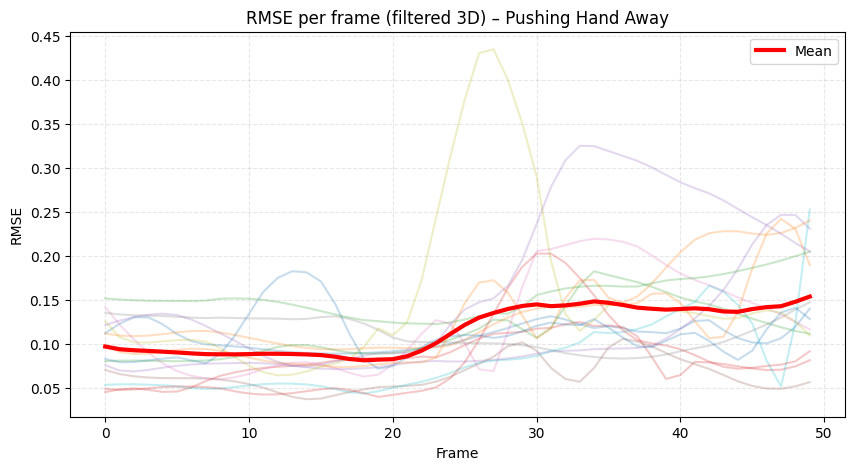

I0000 00:00:1765108862.722475    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.1095751 , 0.13136058, 0.1178571 , 0.08507271, 0.11398042,
       0.06699211, 0.13522009, 0.11378126, 0.18016655, 0.09355928,
       0.11387609, 0.14483428, 0.15490475, 0.09508817, 0.1962649 ]), array([[0.11187703, 0.12266135, 0.13007411, 0.12990332, 0.12197771,
        0.11076967, 0.10284219, 0.09919277, 0.0981129 , 0.09691877,
        0.09536745, 0.09357415, 0.09174186, 0.09034572, 0.08940416,
        0.08886513, 0.08862628, 0.08883517, 0.08929177, 0.09019183,
        0.09136283, 0.09293422, 0.09455875, 0.09655627, 0.09967212,
        0.10421293, 0.10891759, 0.11310328, 0.11775075, 0.12284203,
        0.12786308, 0.13119778, 0.12748042, 0.12192786, 0.11781555,
        0.11983321, 0.11768002, 0.11373775, 0.11315231, 0.11185652,
        0.1171065 , 0.12581917, 0.12660751, 0.11529218, 0.10631364,
        0.10137234, 0.10031426, 0.10618813, 0.11920011, 0.13983662],
       [0.11142893, 0.10919165, 0.1085311 , 0.10915538, 0.11080119,
        0.11285959, 0.11426281, 0.11449422, 0.1

I0000 00:00:1765108862.723504  677000 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108862.771062  676984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108862.806123  676993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.47it/s]
I0000 00:00:1765108863.662390    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765108863.663961  677051 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765108863.717186  677041 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/86669.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108867.472438  677239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108867.500279  677246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.98it/s]
I0000 00:00:1765108868.308299    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108868.309482  677306 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108868.359375  677290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108868.386365  677300 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/28616.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108908.185953  679558 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108908.232398  679543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108908.266353  679554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.31it/s]
I0000 00:00:1765108909.066196    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108909.067538  679609 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108909.116763  679595 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/100122.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108917.141092  680054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108917.165976  680063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.39it/s]
I0000 00:00:1765108918.084300    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108918.085669  680121 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108918.137702  680103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108918.165804  680112 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/88437.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108949.810609  681911 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108949.861772  681896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108949.890073  681907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.90it/s]
I0000 00:00:1765108950.745947    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108950.747472  681962 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108950.800129  681946 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/102593.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108957.074736  682320 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108957.110280  682303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108957.140659  682302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.22it/s]
I0000 00:00:1765108957.970688    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108957.971906  682371 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108958.024697  682358 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/110038.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765108976.304109  683393 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108976.351727  683381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108976.379701  683388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.58it/s]
I0000 00:00:1765108977.232752    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108977.235496  683444 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108977.283542  683426 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/23539.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108984.346633  683839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108984.378189  683848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.90it/s]
I0000 00:00:1765108985.248439    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765108985.250692  683903 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765108985.302367  683887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765108985.328989  683898 inference_feedback_ma

➡️ 143 trajectoires 3D extraites

📊 RMSE moyen avant filtrage : 0.3824
📈 RMSE max : 1.0676
🧹 Filtrage 3D : 78/143 vidéos gardées (< 0.3)

📊 RMSE moyen après filtrage : 0.1403
📈 RMSE max : 0.3340
📉 RMSE min : 0.0623

💾 Dataset + DMP 3D sauvegardés dans datasets_3D/Shaking Hand.joblib


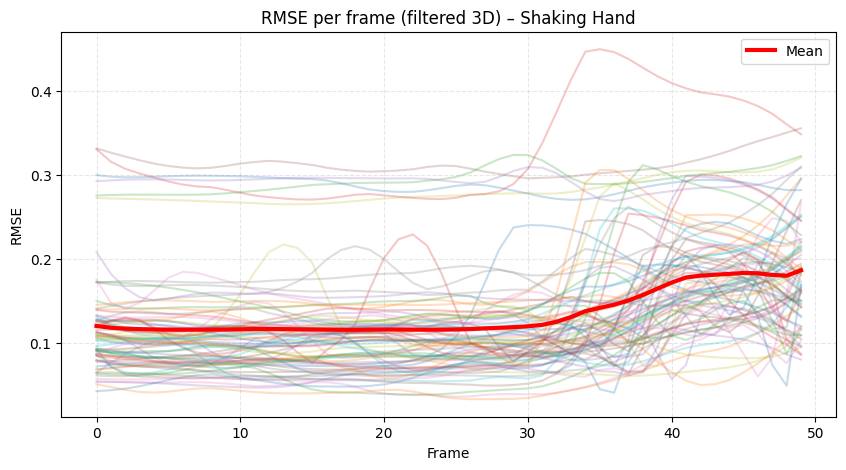

(array([0.14305058, 0.15957593, 0.11699124, 0.14682127, 0.08329265,
       0.13575392, 0.11996599, 0.11574487, 0.28173277, 0.13107408,
       0.13538888, 0.14179349, 0.1462201 , 0.11695393, 0.13595903,
       0.1001392 , 0.13685094, 0.13642771, 0.1192603 , 0.13955031,
       0.10815308, 0.1694997 , 0.11689289, 0.12635018, 0.12520703,
       0.10495695, 0.06444015, 0.13507868, 0.1077428 , 0.14201785,
       0.12809152, 0.15179525, 0.10671373, 0.12874421, 0.15342534,
       0.11314963, 0.14577223, 0.08748582, 0.11595528, 0.11077061,
       0.09098591, 0.11321473, 0.08556498, 0.14912286, 0.10281593,
       0.10794853, 0.08917871, 0.17079594, 0.16932998, 0.14823263,
       0.15181909, 0.08816437, 0.14307076, 0.1741283 , 0.12094692,
       0.10404567, 0.10285158, 0.12660042, 0.11941631, 0.11690283,
       0.13181876, 0.06225958, 0.29462317, 0.10837642, 0.16105225,
       0.31388681, 0.12412165, 0.16522203, 0.13383812, 0.09383603,
       0.28877463, 0.16422499, 0.16504394, 0.33402596, 0.2925

In [98]:
def analyse_full_jester(): 
    for i in labels_jester:
        print(analyse_label_filtered_3D(i, n = 150, target_len=50, n_basis=30, rmse_threshold=0.3)) 
    
analyse_full_jester()